# Making Gas Density Radial Profiles of all Galaxies in the VERTICO Sample

Note that there are only 49 galaxies in this analysis because two galaxies (IC 3481 and
VCC 1581) are non-detections.


In [1]:
%cd "/arc/home/IsaacCheng/coop_f2021/galaxies/gas_densities/"

import numpy as np
import pandas as pd
import dill
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import astropy.coordinates as coord
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
# 
# Load my own packages
# 
import sys
sys.path.append("/arc/home/IsaacCheng/coop_f2021/packages")
import fits_utils as fu
import plot_utils as pu
import radial_profile_utils as rpu
from radial_profile import RadialProfile
# Reload my packages
import importlib
importlib.reload(fu)
importlib.reload(pu)
importlib.reload(rpu)

/arc/home/IsaacCheng/coop_f2021/galaxies/gas_densities


<module 'radial_profile_utils' from '/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py'>

12h53m29.06665721s +02d10m05.49999998s
Getting minimum width from radio beam size
Min width/beam size (pixels): 4.50000000009684


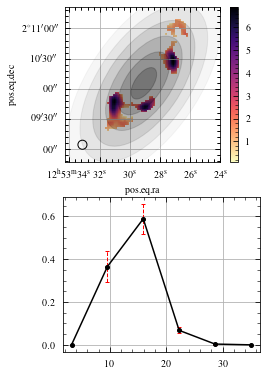

[0.         0.36488832 0.58790969 0.06762815 0.00361731 0.        ]
[0.         0.00535122 0.00481401 0.00197855 0.00042694 0.        ]


In [2]:
# Testing stuff

tmpgal = "NGC4772"
tmppath = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/{tmpgal}/{tmpgal}_7m+tp_co21_pbcorr_9as_round_mom0_Kkms-1.fits"
tmpuncpath = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/{tmpgal}/{tmpgal}_7m+tp_co21_pbcorr_9as_round_mom0_unc.fits"
# tmppath = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3.1/native/{tmpgal}/{tmpgal}_7m+tp_co21_pbcorr_round_mom0_Kkms-1.fits"
# tmpuncpath = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3.1/native/{tmpgal}/{tmpgal}_7m+tp_co21_pbcorr_round_mom0_unc.fits"
tmpdata, tmpheader = fits.getdata(tmppath, header=True)
tmpunc = fits.getdata(tmpuncpath)
tmpcen = WCS(tmpheader).pixel_to_world(tmpdata.shape[1]/2, tmpdata.shape[0]/2)
print(tmpcen.to_string('hmsdms'))

tmpmask = np.isfinite(tmpdata) & np.isfinite(tmpunc)
tmpdata[~tmpmask] = np.nan
tmpunc[~tmpmask] = np.nan

tmpdata = tmpdata * 4.35 / 0.8
tmpunc = tmpunc * 4.35 / 0.8
tmprp = RadialProfile(tmpdata, tmpcen, 60, 325, noise=tmpunc)
tmprp = tmprp.calc_radial_profile(
    # snr_cutoff=0,
    n_annuli=6,
    min_width=None,
    header=tmpheader,
    include_bad=True,
    method="exact",
    func="mean",
    is_radio=True,
    high_i_height=None,
    bootstrap_errs=True,
    bootstrap_seed=314,
)
tmprp = tmprp.correct_for_i(i_replacement=80)

fig = plt.figure(figsize=mpl.figure.figaspect(1.5))
ax1 = fig.add_subplot(2, 1, 1, projection=WCS(tmpheader))
img = ax1.imshow(tmpdata, cmap="magma_r")
fig.colorbar(img)
for num, annulus in enumerate(tmprp.annuli[::-1]):
    try:
        # EllipticalAnnulus attributes
        width = annulus.b_out
        height = annulus.a_out
    except AttributeError:
        # EllipticalAperture attributes
        width = annulus.b
        height = annulus.a
    ellipse = mpl.patches.Ellipse(
        xy=annulus.positions,
        width=width * 2,  # full major/minor axis
        height=height * 2,  # full major/minor axis
        angle=(np.rad2deg(annulus.theta) - 90) % 360.0,  # since PA is 0 deg at North
        ls="-",
        edgecolor="k",
        fc="k",
        alpha=0.2 * (num + 1) / len(tmprp.annuli),
        lw=1,
        zorder=2,
    )
    ax1.add_patch(ellipse)
co_beam_major, co_beam_minor, co_beam_pa = rpu.get_beam_size_px(tmpheader)
xbeam, ybeam = 8, 8
ellipse = mpl.patches.Ellipse(
    xy=(xbeam, ybeam),
    width=co_beam_minor,
    height=co_beam_major,
    angle=(co_beam_pa - 90) % 360.0,  # PA is 0 deg at North & increases CCW by convention
    ls="-",
    edgecolor="k",
    fc="None",
    lw=1,
    zorder=2,
)
ax1.add_patch(ellipse)
# 
ax2 = fig.add_subplot(2, 1, 2)
ebar2 = ax2.errorbar(
    x=tmprp.radii,
    y=tmprp.avg_data,
    yerr=tmprp.avg_data_err,  # uncertainty in the mean/median from bootstrapping
    fmt="-o",
    markersize=4,
    color="k",
    ecolor="r",
    elinewidth=1,
    capsize=2,
)
ebar2[-1][0].set_linestyle("--")
fig.tight_layout(pad=3.5)
plt.show()

print(tmprp.avg_data)
print(tmprp.avg_noise)

# Run ellipse-fitting on all galaxies (already done)


In [2]:
# Parameters & values

galaxies = [
    "IC3392", "NGC4064", "NGC4189", "NGC4192", "NGC4216", "NGC4222", "NGC4254",
    "NGC4293", "NGC4294", "NGC4298", "NGC4299", "NGC4302", "NGC4321", "NGC4330",
    "NGC4351", "NGC4380", "NGC4383", "NGC4388", "NGC4394", "NGC4396", "NGC4402",
    "NGC4405", "NGC4419", "NGC4424", "NGC4450", "NGC4457", "NGC4501", "NGC4522",
    "NGC4532", "NGC4533", "NGC4535", "NGC4536", "NGC4548", "NGC4561", "NGC4567",
    "NGC4568", "NGC4569", "NGC4579", "NGC4580", "NGC4606", "NGC4607", "NGC4651",
    "NGC4654", "NGC4689", "NGC4694", "NGC4698", "NGC4713", "NGC4772", "NGC4808",
]  # 49 galaxies

inclinations = [
    68, 70, 42, 83, 90, 90, 39, 67, 74, 52, 14, 90, 32, 90, 48, 61, 56, 83, 32, 83, 80,
    46, 74, 61, 51, 37, 65, 82, 64, 80, 48, 74, 37, 28, 49, 70, 69, 40, 46, 69, 90, 53,
    61, 38, 62, 66, 45, 60, 72
]  # degrees

position_angles = [
    219, 150, 70, 333, 20, 238, 243, 239, 151, 132, 128, 356, 280, 238, 251, 158, 17, 271,
    312, 304, 270, 18, 131, 274, 170, 256, 320, 35, 159, 342, 12, 118, 318, 60, 251, 211,
    203, 273, 337, 38, 2, 75, 300, 341, 323, 347, 89, 325, 127
]  # degrees

ALPHA_CO = 4.35  # M_sun/pc^2 per (K km/s)
R_21 = 0.8  # dimensionless. CO(2-1)/CO(1-0) ratio

In [3]:
# 
# Parameters
# 
I_THRESHOLD = 80  # degrees
I_REPLACEMENT = 80  # degrees
# SNR_CUTOFF = 0  # fit until no gas detected. some pathological galaxies do not have CO in centre
MAX_SNR_ANNULI = 40
MIN_WIDTH = None  # get from header
# INCLUDE_BAD = False  # changes depending if low- or high-inclination galaxy
PHOTUTILS_METHOD = "exact"
AVG_FUNCTION = "mean"
IS_RADIO = True
HIGH_I_HEIGHT = None  # extend high-i rectangles to image borders
BOOTSTRAP_ERRS = True
BOOTSTRAP_SEED = 2021
# 
# Calculate radial profiles of all the galaxies
# 
centers = []
n_annulis = []
snr_cutoffs = []
include_bads = []
radial_profiles = []
for galaxy, i, pa in zip(galaxies, inclinations, position_angles):
    print("\nProcessing", galaxy)
    # Load data
    if galaxy == "NGC4321":  # no 9 arcsec data since native is 10 arcsec
        Ico_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3.1/native/{galaxy}/{galaxy}_7m+tp_co21_pbcorr_round_mom0_Kkms-1.fits"
        Ico_unc_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3.1/native/{galaxy}/{galaxy}_7m+tp_co21_pbcorr_round_mom0_unc.fits"
    else:
        Ico_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/{galaxy}/{galaxy}_7m+tp_co21_pbcorr_9as_round_mom0_Kkms-1.fits"
        Ico_unc_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/{galaxy}/{galaxy}_7m+tp_co21_pbcorr_9as_round_mom0_unc.fits"
    Ico_data, gal_header = fits.getdata(Ico_path, header=True)
    Ico_unc = fits.getdata(Ico_unc_path)  # uncertainty
    gal_wcs = WCS(gal_header)
    # Set parameters
    # centre = coord.SkyCoord(  # not always accurate
    #     ra=gal_header["OBSRA"],
    #     dec=gal_header["OBSDEC"],
    #     frame=gal_header["RADESYS"].lower(),
    #     unit=gal_header["CUNIT1"].lower(),
    # )
    centre = gal_wcs.pixel_to_world(Ico_data.shape[1] / 2, Ico_data.shape[0] / 2)
    centers.append(centre)
    include_bad = True if i < I_THRESHOLD else False  # only include NaNs if low-i galaxy
    include_bads.append(include_bad)
    if galaxy == "NGC4698" or galaxy == "NGC4772":
        snr_cutoff = None
        n_annuli = 5
    else:
        snr_cutoff = 0  # fit until no gas detected
        n_annuli = None
    n_annulis.append(n_annuli)
    snr_cutoffs.append(snr_cutoff)
    # Mask background
    Ico_mask = (~np.isfinite(Ico_unc)) | (Ico_unc <= 0)
    Ico_data[Ico_mask] = np.nan
    Ico_unc[Ico_mask] = np.nan
    # Convert to gas density (M_sun/pc^2)
    gas_density_i_uncorr = ALPHA_CO / R_21 * Ico_data
    gas_density_unc_i_uncorr = ALPHA_CO / R_21 * Ico_unc
    # Make radial profile
    galaxy_rp = RadialProfile(
        gas_density_i_uncorr, centre, i, pa, noise=gas_density_unc_i_uncorr
    )
    galaxy_rp = galaxy_rp.calc_radial_profile(
        i_threshold=I_THRESHOLD,
        n_annuli=n_annuli,
        snr_cutoff=snr_cutoff,
        max_snr_annuli=MAX_SNR_ANNULI,
        min_width=MIN_WIDTH,
        header=gal_header,
        include_bad=include_bad,
        method=PHOTUTILS_METHOD,
        func=AVG_FUNCTION,
        is_radio=IS_RADIO,
        high_i_height=HIGH_I_HEIGHT,
        bootstrap_errs=BOOTSTRAP_ERRS,
        bootstrap_seed=BOOTSTRAP_SEED,
    )
    galaxy_rp = galaxy_rp.correct_for_i(i_replacement=I_REPLACEMENT)
    radial_profiles.append(galaxy_rp)
# 
# Pickle results
# 
rp_outfile = "/arc/home/IsaacCheng/coop_f2021/galaxies/gas_densities/gas_density_i_corr_allVERTICO.pkl"
with open(rp_outfile, "wb") as f:
    dill.dump(
        {
            "galaxies": galaxies,
            "inclinations": inclinations,
            "position_angles": position_angles,
            "centers": centers,
            "i_threshold": I_THRESHOLD,
            "i_replacement": I_REPLACEMENT,
            "n_annulis": n_annulis,
            "snr_cutoffs": snr_cutoffs,
            "max_snr_annuli": MAX_SNR_ANNULI,
            "min_width": MIN_WIDTH,
            "include_bads": include_bads,
            "photutils_method": PHOTUTILS_METHOD,
            "avg_function": AVG_FUNCTION,
            "is_radio": IS_RADIO,
            "high_i_height": HIGH_I_HEIGHT,
            "bootstrap_errs": BOOTSTRAP_ERRS,
            "bootstrap_seed": BOOTSTRAP_SEED,
            "radial_profiles": radial_profiles,
        },
        f
    )
print(f"\nPickled {rp_outfile}")



Processing IC3392
Getting minimum width from radio beam size
Min width/beam size (pixels): 4.50000000012024
Info: Fitting annuli according to snr_cutoff. Warning messages (e.g., invalid values, degrees of freedom <= 0, etc.) can safely be ignored
Iter 1: average SNR = 886.298265369307
Iter 2: average SNR = 264.2230272854141
Iter 3: average SNR = 1.4651611082404488
Stopped creating ellipses/annuli after 3 iterations
Average SNR of most recent successful fit: 1.4651611082404488
Average SNR of next annulus: nan

Processing NGC4064


/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:945: RuntimeWarning: invalid value encountered in double_scalars
  avg_snr = avg_data / avg_noise
/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:945: RuntimeWarning: invalid value encountered in double_scalars
  avg_snr = avg_data / avg_noise


Getting minimum width from radio beam size
Min width/beam size (pixels): 4.500000001059839
Info: Fitting annuli according to snr_cutoff. Warning messages (e.g., invalid values, degrees of freedom <= 0, etc.) can safely be ignored
Iter 1: average SNR = 902.0765021665366
Iter 2: average SNR = 144.91279032429784
Iter 3: average SNR = 1.4520818508213682
Stopped creating ellipses/annuli after 3 iterations
Average SNR of most recent successful fit: 1.4520818508213682
Average SNR of next annulus: nan

Processing NGC4189
Getting minimum width from radio beam size
Min width/beam size (pixels): 4.50000000022464
Info: Fitting annuli according to snr_cutoff. Warning messages (e.g., invalid values, degrees of freedom <= 0, etc.) can safely be ignored
Iter 1: average SNR = 327.2968068878628
Iter 2: average SNR = 324.39377171926054
Iter 3: average SNR = 425.47713220528044
Iter 4: average SNR = 365.66571240615286
Iter 5: average SNR = 167.88835198539167
Iter 6: average SNR = 39.70417480664735
Stopped 

/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:945: RuntimeWarning: invalid value encountered in double_scalars
  avg_snr = avg_data / avg_noise



Processing NGC4192
Getting minimum width from radio beam size
Min width/beam size (pixels): 4.49773120432584
Info: Inclination greater than i_threshold. Fitting rectangles along major axis instead of ellipses/annuli
Info: Fitting rectangles according to snr_cutoff. Warning messages (e.g., invalid values, degrees of freedom <= 0, etc.) can safely be ignored
Iter 1: average SNR = 977.0103967475616
Iter 2: average SNR = 844.1189185931804
Iter 3: average SNR = 390.9880211555724
Iter 4: average SNR = 274.18637265639177
Iter 5: average SNR = 191.97232420498446
Iter 6: average SNR = 207.5431682746823
Iter 7: average SNR = 266.2949180999793
Iter 8: average SNR = 315.31697743374434
Iter 9: average SNR = 310.62826078628746
Iter 10: average SNR = 387.13254646321695
Iter 11: average SNR = 376.7561920963187
Iter 12: average SNR = 381.01495476659306
Iter 13: average SNR = 357.2360070497764
Iter 14: average SNR = 338.00814039071565
Iter 15: average SNR = 323.82543938604675
Iter 16: average SNR = 192

/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:607: RuntimeWarning: invalid value encountered in double_scalars
  avg_signal = avg_signal / np.nansum(signal_area_mask)
/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:613: RuntimeWarning: invalid value encountered in double_scalars
  avg_noise = np.sqrt(avg_noise) / np.nansum(noise_area_mask)
/opt/conda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Stopped creating rectangles after 19 iterations
Average SNR of most recent successful fit: 73.08712062905576
Average SNR of next rectangle: nan

Processing NGC4216
Getting minimum width from radio beam size
Min width/beam size (pixels): 4.50000000019044
Info: Inclination greater than i_threshold. Fitting rectangles along major axis instead of ellipses/annuli
Info: Fitting rectangles according to snr_cutoff. Warning messages (e.g., invalid values, degrees of freedom <= 0, etc.) can safely be ignored
Iter 1: average SNR = 153.12446553071703


Iter 2: average SNR = 228.4770689769012
Iter 3: average SNR = 240.50013962581255
Iter 4: average SNR = 237.46182387284586
Iter 5: average SNR = 256.88927325402125
Iter 6: average SNR = 288.80329901835773
Iter 7: average SNR = 241.74063459586836
Iter 8: average SNR = 218.43554227203873
Iter 9: average SNR = 210.28851129537523
Iter 10: average SNR = 234.58035350700888
Iter 11: average SNR = 300.3840717484741
Iter 12: average SNR = 329.37122623677686
Iter 13: average SNR = 290.423297114779
Iter 14: average SNR = 246.76689258942207
Iter 15: average SNR = 252.05789764215135
Iter 16: average SNR = 298.11039734851477
Iter 17: average SNR = 244.75046740494017
Iter 18: average SNR = 214.7204754145246
Iter 19: average SNR = 172.63792396812795
Iter 20: average SNR = 176.9057890008069
Iter 21: average SNR = 100.9192283005807


/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:607: RuntimeWarning: invalid value encountered in double_scalars
  avg_signal = avg_signal / np.nansum(signal_area_mask)
/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:613: RuntimeWarning: invalid value encountered in double_scalars
  avg_noise = np.sqrt(avg_noise) / np.nansum(noise_area_mask)
/opt/conda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Stopped creating rectangles after 21 iterations
Average SNR of most recent successful fit: 100.9192283005807
Average SNR of next rectangle: nan

Processing NGC4222
Getting minimum width from radio beam size
Min width/beam size (pixels): 4.50000000020844
Info: Inclination greater than i_threshold. Fitting rectangles along major axis instead of ellipses/annuli
Info: Fitting rectangles according to snr_cutoff. Warning messages (e.g., invalid values, degrees of freedom <= 0, etc.) can safely be ignored
Iter 1: average SNR = 182.35534875744784
Iter 2: average SNR = 310.0274631761011
Iter 3: average SNR = 301.06813747134527
Iter 4: average SNR = 175.2566137896523


Iter 5: average SNR = 119.54596379905324
Iter 6: average SNR = 98.09905698719642
Iter 7: average SNR = 126.49264505515309
Iter 8: average SNR = 41.87415591758066
Iter 9: average SNR = 1.6951300011923929


/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:607: RuntimeWarning: invalid value encountered in double_scalars
  avg_signal = avg_signal / np.nansum(signal_area_mask)
/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:613: RuntimeWarning: invalid value encountered in double_scalars
  avg_noise = np.sqrt(avg_noise) / np.nansum(noise_area_mask)
/opt/conda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Stopped creating rectangles after 9 iterations
Average SNR of most recent successful fit: 1.6951300011923929
Average SNR of next rectangle: nan

Processing NGC4254
Getting minimum width from radio beam size
Min width/beam size (pixels): 4.50000000022464
Info: Fitting annuli according to snr_cutoff. Warning messages (e.g., invalid values, degrees of freedom <= 0, etc.) can safely be ignored
Iter 1: average SNR = 1324.2732206945304
Iter 2: average SNR = 1541.8612576715052
Iter 3: average SNR = 1738.5907420288481
Iter 4: average SNR = 1361.7563607401137
Iter 5: average SNR = 1212.829913942254
Iter 6: average SNR = 961.0121936597675
Iter 7: average SNR = 754.7756505984684
Iter 8: average SNR = 684.8906247168168
Iter 9: average SNR = 432.4243788928052


/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:945: RuntimeWarning: invalid value encountered in double_scalars
  avg_snr = avg_data / avg_noise


Iter 10: average SNR = 291.02847277212396
Iter 11: average SNR = 319.59495233880904
Iter 12: average SNR = 229.07128190278212
Iter 13: average SNR = 201.81599046112726
Iter 14: average SNR = 125.36055436989929
Iter 15: average SNR = 86.20059916420924
Iter 16: average SNR = 0.583443504206923
Stopped creating ellipses/annuli after 16 iterations
Average SNR of most recent successful fit: 0.583443504206923
Average SNR of next annulus: nan

Processing NGC4293


/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:945: RuntimeWarning: invalid value encountered in double_scalars
  avg_snr = avg_data / avg_noise


Getting minimum width from radio beam size
Min width/beam size (pixels): 4.50000000005724
Info: Fitting annuli according to snr_cutoff. Warning messages (e.g., invalid values, degrees of freedom <= 0, etc.) can safely be ignored
Iter 1: average SNR = 1884.6471867186683
Iter 2: average SNR = 418.8741039916741
Iter 3: average SNR = 146.43260408332569
Iter 4: average SNR = 33.45975007200918
Iter 5: average SNR = 1.3433839528419071
Stopped creating ellipses/annuli after 5 iterations
Average SNR of most recent successful fit: 1.3433839528419071
Average SNR of next annulus: nan

Processing NGC4294


/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:945: RuntimeWarning: invalid value encountered in double_scalars
  avg_snr = avg_data / avg_noise


Getting minimum width from radio beam size
Min width/beam size (pixels): 4.50000000020304
Info: Fitting annuli according to snr_cutoff. Warning messages (e.g., invalid values, degrees of freedom <= 0, etc.) can safely be ignored
Iter 1: average SNR = 227.05383203282304
Iter 2: average SNR = 108.17102165832826
Iter 3: average SNR = 24.727468283797062
Stopped creating ellipses/annuli after 3 iterations
Average SNR of most recent successful fit: 24.727468283797062
Average SNR of next annulus: nan

Processing NGC4298
Getting minimum width from radio beam size
Min width/beam size (pixels): 4.50000000019764
Info: Fitting annuli according to snr_cutoff. Warning messages (e.g., invalid values, degrees of freedom <= 0, etc.) can safely be ignored
Iter 1: average SNR = 849.3168891083394
Iter 2: average SNR = 960.5256640376367
Iter 3: average SNR = 787.8849931772166
Iter 4: average SNR = 600.744734808176
Iter 5: average SNR = 410.4508374185864
Iter 6: average SNR = 187.62627233608612
Iter 7: aver

/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:945: RuntimeWarning: invalid value encountered in double_scalars
  avg_snr = avg_data / avg_noise
/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:945: RuntimeWarning: invalid value encountered in double_scalars
  avg_snr = avg_data / avg_noise


Stopped creating ellipses/annuli after 6 iterations
Average SNR of most recent successful fit: 10.94181925609335
Average SNR of next annulus: nan

Processing NGC4302
Getting minimum width from radio beam size
Min width/beam size (pixels): 4.500000000075239
Info: Inclination greater than i_threshold. Fitting rectangles along major axis instead of ellipses/annuli
Info: Fitting rectangles according to snr_cutoff. Warning messages (e.g., invalid values, degrees of freedom <= 0, etc.) can safely be ignored


Iter 1: average SNR = 1173.9561970271084
Iter 2: average SNR = 1143.328691128849
Iter 3: average SNR = 986.4009867370968
Iter 4: average SNR = 899.5451791235539
Iter 5: average SNR = 770.7834249044987
Iter 6: average SNR = 719.3211365190036
Iter 7: average SNR = 593.5831619185567
Iter 8: average SNR = 547.8883608954887
Iter 9: average SNR = 473.1044262762016
Iter 10: average SNR = 414.31675524811664
Iter 11: average SNR = 313.5314430412977
Iter 12: average SNR = 237.91580611671117
Iter 13: average SNR = 161.9989480715804
Iter 14: average SNR = 127.20249388574605
Iter 15: average SNR = 68.5823734411041
Iter 16: average SNR = 74.29968933137215
Iter 17: average SNR = 52.567627790669256
Iter 18: average SNR = 7.859659050191485


/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:607: RuntimeWarning: invalid value encountered in double_scalars
  avg_signal = avg_signal / np.nansum(signal_area_mask)
/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:613: RuntimeWarning: invalid value encountered in double_scalars
  avg_noise = np.sqrt(avg_noise) / np.nansum(noise_area_mask)
/opt/conda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Stopped creating rectangles after 18 iterations
Average SNR of most recent successful fit: 7.859659050191485
Average SNR of next rectangle: nan

Processing NGC4321
Getting minimum width from radio beam size
Min width/beam size (pixels): 5.092956068889193
Info: Fitting annuli according to snr_cutoff. Warning messages (e.g., invalid values, degrees of freedom <= 0, etc.) can safely be ignored
Iter 1: average SNR = 2491.975040067827
Iter 2: average SNR = 1386.1895633597153
Iter 3: average SNR = 647.6232657407112
Iter 4: average SNR = 715.5220809372605
Iter 5: average SNR = 877.9795225823862
Iter 6: average SNR = 793.8460334091253
Iter 7: average SNR = 703.6474429441893
Iter 8: average SNR = 672.4430042503932
Iter 9: average SNR = 561.1148761685305
Iter 10: average SNR = 468.21455068980976
Iter 11: average SNR = 351.2191106245169
Iter 12: average SNR = 308.55534746877794
Iter 13: average SNR = 190.34601371683794


/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:945: RuntimeWarning: invalid value encountered in double_scalars
  avg_snr = avg_data / avg_noise


Iter 14: average SNR = 135.71917325810688
Iter 15: average SNR = 32.24891288618642
Stopped creating ellipses/annuli after 15 iterations
Average SNR of most recent successful fit: 32.24891288618642
Average SNR of next annulus: nan

Processing NGC4330
Getting minimum width from radio beam size
Min width/beam size (pixels): 4.50000000016344
Info: Inclination greater than i_threshold. Fitting rectangles along major axis instead of ellipses/annuli
Info: Fitting rectangles according to snr_cutoff. Warning messages (e.g., invalid values, degrees of freedom <= 0, etc.) can safely be ignored
Iter 1: average SNR = 354.19108554519374
Iter 2: average SNR = 400.6847367740846


Iter 3: average SNR = 301.4270193082337
Iter 4: average SNR = 254.7539017838633
Iter 5: average SNR = 218.4919432554885
Iter 6: average SNR = 164.00445021282087
Iter 7: average SNR = 104.6918138149734
Iter 8: average SNR = 69.20911556904873
Iter 9: average SNR = 8.938800703816952


/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:607: RuntimeWarning: invalid value encountered in double_scalars
  avg_signal = avg_signal / np.nansum(signal_area_mask)
/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:613: RuntimeWarning: invalid value encountered in double_scalars
  avg_noise = np.sqrt(avg_noise) / np.nansum(noise_area_mask)
/opt/conda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Stopped creating rectangles after 9 iterations
Average SNR of most recent successful fit: 8.938800703816952
Average SNR of next rectangle: nan

Processing NGC4351
Getting minimum width from radio beam size
Min width/beam size (pixels): 4.5000000002840395
Info: Fitting annuli according to snr_cutoff. Warning messages (e.g., invalid values, degrees of freedom <= 0, etc.) can safely be ignored
Iter 1: average SNR = 184.85616640415395
Iter 2: average SNR = 151.63405837209558
Iter 3: average SNR = 82.33552425764105
Iter 4: average SNR = 24.003650258861605
Iter 5: average SNR = 4.415454245876479
Stopped creating ellipses/annuli after 5 iterations
Average SNR of most recent successful fit: 4.415454245876479
Average SNR of next annulus: nan

Processing NGC4380
Getting minimum width from radio beam size
Min width/beam size (pixels): 4.50000000014364
Info: Fitting annuli according to snr_cutoff. Warning messages (e.g., invalid values, degrees of freedom <= 0, etc.) can safely be ignored
Iter 1: 

/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:945: RuntimeWarning: invalid value encountered in double_scalars
  avg_snr = avg_data / avg_noise
/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:945: RuntimeWarning: invalid value encountered in double_scalars
  avg_snr = avg_data / avg_noise


Stopped creating ellipses/annuli after 5 iterations
Average SNR of most recent successful fit: 92.37610579216081
Average SNR of next annulus: nan

Processing NGC4383
Getting minimum width from radio beam size
Min width/beam size (pixels): 4.500000000210241
Info: Fitting annuli according to snr_cutoff. Warning messages (e.g., invalid values, degrees of freedom <= 0, etc.) can safely be ignored
Iter 1: average SNR = 569.5202367005787
Iter 2: average SNR = 303.6275997174621
Iter 3: average SNR = 83.97762893561584
Iter 4: average SNR = 27.32817202669266


/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:945: RuntimeWarning: invalid value encountered in double_scalars
  avg_snr = avg_data / avg_noise


Iter 5: average SNR = 2.4335538933853162
Stopped creating ellipses/annuli after 5 iterations
Average SNR of most recent successful fit: 2.4335538933853162
Average SNR of next annulus: nan

Processing NGC4388
Getting minimum width from radio beam size
Min width/beam size (pixels): 4.5000000001472396
Info: Inclination greater than i_threshold. Fitting rectangles along major axis instead of ellipses/annuli
Info: Fitting rectangles according to snr_cutoff. Warning messages (e.g., invalid values, degrees of freedom <= 0, etc.) can safely be ignored
Iter 1: average SNR = 1242.289124328424
Iter 2: average SNR = 1179.3968196197047
Iter 3: average SNR = 943.8837878944214
Iter 4: average SNR = 903.7136889104496
Iter 5: average SNR = 614.2920144307664
Iter 6: average SNR = 306.77352189777275
Iter 7: average SNR = 245.6152179878696
Iter 8: average SNR = 219.94987683694492
Iter 9: average SNR = 92.23053727277745
Iter 10: average SNR = 7.6526658569198664


/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:607: RuntimeWarning: invalid value encountered in double_scalars
  avg_signal = avg_signal / np.nansum(signal_area_mask)
/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:613: RuntimeWarning: invalid value encountered in double_scalars
  avg_noise = np.sqrt(avg_noise) / np.nansum(noise_area_mask)
/opt/conda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Stopped creating rectangles after 10 iterations
Average SNR of most recent successful fit: 7.6526658569198664
Average SNR of next rectangle: nan

Processing NGC4394
Getting minimum width from radio beam size
Min width/beam size (pixels): 4.50000000008964
Info: Fitting annuli according to snr_cutoff. Warning messages (e.g., invalid values, degrees of freedom <= 0, etc.) can safely be ignored
Iter 1: average SNR = 258.98273233987334
Iter 2: average SNR = 44.51846047094245
Iter 3: average SNR = 78.633581081134
Iter 4: average SNR = 152.91653917013315
Iter 5: average SNR = 109.69984031031714
Iter 6: average SNR = 34.15331056247798
Stopped creating ellipses/annuli after 6 iterations
Average SNR of most recent successful fit: 34.15331056247798
Average SNR of next annulus: nan

Processing NGC4396


/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:945: RuntimeWarning: invalid value encountered in double_scalars
  avg_snr = avg_data / avg_noise


Getting minimum width from radio beam size
Min width/beam size (pixels): 4.50000000012564
Info: Inclination greater than i_threshold. Fitting rectangles along major axis instead of ellipses/annuli
Info: Fitting rectangles according to snr_cutoff. Warning messages (e.g., invalid values, degrees of freedom <= 0, etc.) can safely be ignored
Iter 1: average SNR = 148.26302504631448
Iter 2: average SNR = 166.32471987133326
Iter 3: average SNR = 118.54508961943277
Iter 4: average SNR = 78.15855055488129
Iter 5: average SNR = 63.40082336201729
Iter 6: average SNR = 44.09738020569025
Iter 7: average SNR = 43.62557171935283
Iter 8: average SNR = 20.39730022125759


/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:607: RuntimeWarning: invalid value encountered in double_scalars
  avg_signal = avg_signal / np.nansum(signal_area_mask)
/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:613: RuntimeWarning: invalid value encountered in double_scalars
  avg_noise = np.sqrt(avg_noise) / np.nansum(noise_area_mask)
/opt/conda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Stopped creating rectangles after 8 iterations
Average SNR of most recent successful fit: 20.39730022125759
Average SNR of next rectangle: nan

Processing NGC4402
Getting minimum width from radio beam size
Min width/beam size (pixels): 4.500000000188639
Info: Inclination greater than i_threshold. Fitting rectangles along major axis instead of ellipses/annuli
Info: Fitting rectangles according to snr_cutoff. Warning messages (e.g., invalid values, degrees of freedom <= 0, etc.) can safely be ignored
Iter 1: average SNR = 1369.8992117328014
Iter 2: average SNR = 1545.687928557989
Iter 3: average SNR = 1246.0559563159784


Iter 4: average SNR = 1133.5737005662509
Iter 5: average SNR = 1123.4826945773011
Iter 6: average SNR = 1007.0707618219762
Iter 7: average SNR = 593.4912124412498
Iter 8: average SNR = 336.566716088217
Iter 9: average SNR = 87.6897568620808
Iter 10: average SNR = 30.650698165285032
Iter 11: average SNR = 24.427972983986418
Iter 12: average SNR = 15.537628478523887
Iter 13: average SNR = 5.139599944311254
Stopped creating rectangles after 13 iterations
Average SNR of most recent successful fit: 5.139599944311254
Average SNR of next rectangle: nan


/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:607: RuntimeWarning: invalid value encountered in double_scalars
  avg_signal = avg_signal / np.nansum(signal_area_mask)
/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:613: RuntimeWarning: invalid value encountered in double_scalars
  avg_noise = np.sqrt(avg_noise) / np.nansum(noise_area_mask)
/opt/conda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,



Processing NGC4405


/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:945: RuntimeWarning: invalid value encountered in double_scalars
  avg_snr = avg_data / avg_noise
/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:945: RuntimeWarning: invalid value encountered in double_scalars
  avg_snr = avg_data / avg_noise


Getting minimum width from radio beam size
Min width/beam size (pixels): 4.50000000012204
Info: Fitting annuli according to snr_cutoff. Warning messages (e.g., invalid values, degrees of freedom <= 0, etc.) can safely be ignored
Iter 1: average SNR = 642.8183257446476
Iter 2: average SNR = 330.12343902102697
Iter 3: average SNR = 14.179419121933803
Stopped creating ellipses/annuli after 3 iterations
Average SNR of most recent successful fit: 14.179419121933803
Average SNR of next annulus: nan

Processing NGC4419
Getting minimum width from radio beam size
Min width/beam size (pixels): 4.50000000017604
Info: Fitting annuli according to snr_cutoff. Warning messages (e.g., invalid values, degrees of freedom <= 0, etc.) can safely be ignored
Iter 1: average SNR = 4238.036303798713
Iter 2: average SNR = 693.9187051598344
Iter 3: average SNR = 182.28903784094092
Iter 4: average SNR = 189.90160857344486
Stopped creating ellipses/annuli after 4 iterations
Average SNR of most recent successful f

/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:945: RuntimeWarning: invalid value encountered in double_scalars
  avg_snr = avg_data / avg_noise
/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:945: RuntimeWarning: invalid value encountered in double_scalars
  avg_snr = avg_data / avg_noise


Getting minimum width from radio beam size
Min width/beam size (pixels): 4.50000000027684
Info: Fitting annuli according to snr_cutoff. Warning messages (e.g., invalid values, degrees of freedom <= 0, etc.) can safely be ignored
Iter 1: average SNR = 555.6332364596979
Iter 2: average SNR = 342.1095767918372
Iter 3: average SNR = 228.7420595755244
Iter 4: average SNR = 146.55346445631608
Iter 5: average SNR = 217.5250434827499
Iter 6: average SNR = 100.42933538910823
Iter 7: average SNR = 5.335454153959501
Stopped creating ellipses/annuli after 7 iterations
Average SNR of most recent successful fit: 5.335454153959501
Average SNR of next annulus: nan

Processing NGC4457


/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:945: RuntimeWarning: invalid value encountered in double_scalars
  avg_snr = avg_data / avg_noise


Getting minimum width from radio beam size
Min width/beam size (pixels): 4.50000000013464
Info: Fitting annuli according to snr_cutoff. Warning messages (e.g., invalid values, degrees of freedom <= 0, etc.) can safely be ignored
Iter 1: average SNR = 1245.5670348108697
Iter 2: average SNR = 790.7832919146281
Iter 3: average SNR = 538.6072916740712
Iter 4: average SNR = 157.0957694830616
Iter 5: average SNR = 73.3185849889232
Iter 6: average SNR = 1.9780537253456925
Stopped creating ellipses/annuli after 6 iterations
Average SNR of most recent successful fit: 1.9780537253456925
Average SNR of next annulus: nan

Processing NGC4501
Getting minimum width from radio beam size
Min width/beam size (pixels): 4.50000000015804
Info: Fitting annuli according to snr_cutoff. Warning messages (e.g., invalid values, degrees of freedom <= 0, etc.) can safely be ignored
Iter 1: average SNR = 1688.6438179070685
Iter 2: average SNR = 1711.3176612555685
Iter 3: average SNR = 1835.6552600359266
Iter 4: ave

/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:945: RuntimeWarning: invalid value encountered in double_scalars
  avg_snr = avg_data / avg_noise


Min width/beam size (pixels): 4.50000000014004
Info: Inclination greater than i_threshold. Fitting rectangles along major axis instead of ellipses/annuli
Info: Fitting rectangles according to snr_cutoff. Warning messages (e.g., invalid values, degrees of freedom <= 0, etc.) can safely be ignored
Iter 1: average SNR = 464.72962652270274
Iter 2: average SNR = 514.8827579953262
Iter 3: average SNR = 317.94453350450857
Iter 4: average SNR = 185.68580055039837
Iter 5: average SNR = 103.92209329459378
Iter 6: average SNR = 54.84669186902118
Iter 7: average SNR = 4.293098939685309
Stopped creating rectangles after 7 iterations
Average SNR of most recent successful fit: 4.293098939685309
Average SNR of next rectangle: nan


/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:607: RuntimeWarning: invalid value encountered in double_scalars
  avg_signal = avg_signal / np.nansum(signal_area_mask)
/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:613: RuntimeWarning: invalid value encountered in double_scalars
  avg_noise = np.sqrt(avg_noise) / np.nansum(noise_area_mask)
/opt/conda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,



Processing NGC4532
Getting minimum width from radio beam size
Min width/beam size (pixels): 4.50000000009684
Info: Fitting annuli according to snr_cutoff. Warning messages (e.g., invalid values, degrees of freedom <= 0, etc.) can safely be ignored
Iter 1: average SNR = 493.7926025364596
Iter 2: average SNR = 239.66304145443232
Iter 3: average SNR = 130.40746712555995
Iter 4: average SNR = 7.929929825909933
Stopped creating ellipses/annuli after 4 iterations
Average SNR of most recent successful fit: 7.929929825909933
Average SNR of next annulus: nan

Processing NGC4533


/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:945: RuntimeWarning: invalid value encountered in double_scalars
  avg_snr = avg_data / avg_noise


Getting minimum width from radio beam size
Min width/beam size (pixels): 4.50000000019224
Info: Inclination greater than i_threshold. Fitting rectangles along major axis instead of ellipses/annuli
Info: Fitting rectangles according to snr_cutoff. Warning messages (e.g., invalid values, degrees of freedom <= 0, etc.) can safely be ignored
Iter 1: average SNR = 99.92712989307206
Iter 2: average SNR = 128.43612449059293
Iter 3: average SNR = 73.0073879649983
Iter 4: average SNR = 38.51011603567632
Iter 5: average SNR = 32.995240317353264
Iter 6: average SNR = 18.020021026747184


/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:607: RuntimeWarning: invalid value encountered in double_scalars
  avg_signal = avg_signal / np.nansum(signal_area_mask)
/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:613: RuntimeWarning: invalid value encountered in double_scalars
  avg_noise = np.sqrt(avg_noise) / np.nansum(noise_area_mask)
/opt/conda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Stopped creating rectangles after 6 iterations
Average SNR of most recent successful fit: 18.020021026747184
Average SNR of next rectangle: nan

Processing NGC4535


/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:945: RuntimeWarning: invalid value encountered in double_scalars
  avg_snr = avg_data / avg_noise


Getting minimum width from radio beam size
Min width/beam size (pixels): 4.50000000014904
Info: Fitting annuli according to snr_cutoff. Warning messages (e.g., invalid values, degrees of freedom <= 0, etc.) can safely be ignored
Iter 1: average SNR = 1043.8441564644752
Iter 2: average SNR = 253.5864472829493
Iter 3: average SNR = 185.0881661917896
Iter 4: average SNR = 450.5399837665307
Iter 5: average SNR = 324.67045641384607
Iter 6: average SNR = 383.5597408691767
Iter 7: average SNR = 476.44566489960334
Iter 8: average SNR = 408.16956921901175
Iter 9: average SNR = 231.3280062280182
Iter 10: average SNR = 85.58847755222268
Iter 11: average SNR = 59.929154810201446
Iter 12: average SNR = 35.71257989776407
Stopped creating ellipses/annuli after 12 iterations
Average SNR of most recent successful fit: 35.71257989776407
Average SNR of next annulus: nan

Processing NGC4536
Getting minimum width from radio beam size
Min width/beam size (pixels): 4.50000000021384
Info: Fitting annuli accor

Iter 8: average SNR = 44.45583647109778
Iter 9: average SNR = 43.237908245975966
Iter 10: average SNR = 6.987650810306625
Stopped creating ellipses/annuli after 10 iterations
Average SNR of most recent successful fit: 6.987650810306625
Average SNR of next annulus: nan


/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:945: RuntimeWarning: invalid value encountered in double_scalars
  avg_snr = avg_data / avg_noise



Processing NGC4548
Getting minimum width from radio beam size
Min width/beam size (pixels): 4.500000000179639
Info: Fitting annuli according to snr_cutoff. Warning messages (e.g., invalid values, degrees of freedom <= 0, etc.) can safely be ignored
Iter 1: average SNR = 378.23564370906917
Iter 2: average SNR = 132.14119130727423
Iter 3: average SNR = 117.86054151607398
Iter 4: average SNR = 139.55551298244905
Iter 5: average SNR = 163.63866404474476
Iter 6: average SNR = 272.04651625435054
Iter 7: average SNR = 429.34460090990916
Iter 8: average SNR = 361.80777582360633
Iter 9: average SNR = 212.19290403768576
Iter 10: average SNR = 131.7343418468254
Iter 11: average SNR = 63.49748985290951
Stopped creating ellipses/annuli after 11 iterations
Average SNR of most recent successful fit: 63.49748985290951
Average SNR of next annulus: nan


/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:945: RuntimeWarning: invalid value encountered in double_scalars
  avg_snr = avg_data / avg_noise



Processing NGC4561
Getting minimum width from radio beam size
Min width/beam size (pixels): 4.50000000012204
Info: Fitting annuli according to snr_cutoff. Warning messages (e.g., invalid values, degrees of freedom <= 0, etc.) can safely be ignored
Iter 1: average SNR = 5.946154793940669
Iter 2: average SNR = 22.798340979941653
Iter 3: average SNR = 34.57809502931789
Iter 4: average SNR = 28.09363524928688
Iter 5: average SNR = 23.730707778955875
Iter 6: average SNR = 8.77323532177573
Stopped creating ellipses/annuli after 6 iterations
Average SNR of most recent successful fit: 8.77323532177573
Average SNR of next annulus: nan

Processing NGC4567


/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:945: RuntimeWarning: invalid value encountered in double_scalars
  avg_snr = avg_data / avg_noise
/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:945: RuntimeWarning: invalid value encountered in double_scalars
  avg_snr = avg_data / avg_noise


Getting minimum width from radio beam size
Min width/beam size (pixels): 4.50000000015984
Info: Fitting annuli according to snr_cutoff. Warning messages (e.g., invalid values, degrees of freedom <= 0, etc.) can safely be ignored
Iter 1: average SNR = 1698.567528095163
Iter 2: average SNR = 1500.8203894654425
Iter 3: average SNR = 940.5430632567823
Iter 4: average SNR = 703.9141241070425
Iter 5: average SNR = 483.43540172027366
Iter 6: average SNR = 15.027693890719462
Stopped creating ellipses/annuli after 6 iterations
Average SNR of most recent successful fit: 15.027693890719462
Average SNR of next annulus: nan

Processing NGC4568
Getting minimum width from radio beam size
Min width/beam size (pixels): 4.50000000021924
Info: Fitting annuli according to snr_cutoff. Warning messages (e.g., invalid values, degrees of freedom <= 0, etc.) can safely be ignored
Iter 1: average SNR = 3603.8721233562956
Iter 2: average SNR = 2213.5471977437837
Iter 3: average SNR = 944.1232133486541
Iter 4: av

/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:945: RuntimeWarning: invalid value encountered in double_scalars
  avg_snr = avg_data / avg_noise


Iter 6: average SNR = 192.5373791671488
Iter 7: average SNR = 141.59153499015895
Iter 8: average SNR = 15.30281220794545
Stopped creating ellipses/annuli after 8 iterations
Average SNR of most recent successful fit: 15.30281220794545
Average SNR of next annulus: nan

Processing NGC4579


/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:945: RuntimeWarning: invalid value encountered in double_scalars
  avg_snr = avg_data / avg_noise
/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:945: RuntimeWarning: invalid value encountered in double_scalars
  avg_snr = avg_data / avg_noise


Getting minimum width from radio beam size
Min width/beam size (pixels): 4.50000000016704
Info: Fitting annuli according to snr_cutoff. Warning messages (e.g., invalid values, degrees of freedom <= 0, etc.) can safely be ignored
Iter 1: average SNR = 1093.259014170651
Iter 2: average SNR = 597.0957787439986
Iter 3: average SNR = 268.32840126019533
Iter 4: average SNR = 459.10935094846235
Iter 5: average SNR = 596.4936849365588
Iter 6: average SNR = 672.2951128162391
Iter 7: average SNR = 605.1669660398693
Iter 8: average SNR = 372.5563948710256
Iter 9: average SNR = 174.46801524187595
Iter 10: average SNR = 32.61758869233081
Iter 11: average SNR = 4.823819401764026
Stopped creating ellipses/annuli after 11 iterations
Average SNR of most recent successful fit: 4.823819401764026
Average SNR of next annulus: nan

Processing NGC4580
Getting minimum width from radio beam size
Min width/beam size (pixels): 4.50000000016344
Info: Fitting annuli according to snr_cutoff. Warning messages (e.g.,

/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:945: RuntimeWarning: invalid value encountered in double_scalars
  avg_snr = avg_data / avg_noise
/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:945: RuntimeWarning: invalid value encountered in double_scalars
  avg_snr = avg_data / avg_noise


Min width/beam size (pixels): 4.50000000011484
Info: Fitting annuli according to snr_cutoff. Warning messages (e.g., invalid values, degrees of freedom <= 0, etc.) can safely be ignored
Iter 1: average SNR = 1341.2483621050355
Iter 2: average SNR = 162.61413747464783
Iter 3: average SNR = 165.1740092170996
Iter 4: average SNR = 146.57002955811552
Iter 5: average SNR = 31.46168987753862
Stopped creating ellipses/annuli after 5 iterations
Average SNR of most recent successful fit: 31.46168987753862
Average SNR of next annulus: nan

Processing NGC4607
Getting minimum width from radio beam size
Min width/beam size (pixels): 4.5000000004406395
Info: Inclination greater than i_threshold. Fitting rectangles along major axis instead of ellipses/annuli
Info: Fitting rectangles according to snr_cutoff. Warning messages (e.g., invalid values, degrees of freedom <= 0, etc.) can safely be ignored
Iter 1: average SNR = 740.0868961211816
Iter 2: average SNR = 934.3942885899991


Iter 3: average SNR = 623.3676187836018
Iter 4: average SNR = 428.9483212979124
Iter 5: average SNR = 313.08149171663223
Iter 6: average SNR = 143.71597794991536
Iter 7: average SNR = 117.35009858641405
Stopped creating rectangles after 7 iterations
Average SNR of most recent successful fit: 117.35009858641405
Average SNR of next rectangle: nan


/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:607: RuntimeWarning: invalid value encountered in double_scalars
  avg_signal = avg_signal / np.nansum(signal_area_mask)
/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:613: RuntimeWarning: invalid value encountered in double_scalars
  avg_noise = np.sqrt(avg_noise) / np.nansum(noise_area_mask)
/opt/conda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,



Processing NGC4651
Getting minimum width from radio beam size
Min width/beam size (pixels): 4.50000000021924
Info: Fitting annuli according to snr_cutoff. Warning messages (e.g., invalid values, degrees of freedom <= 0, etc.) can safely be ignored
Iter 1: average SNR = 515.6181331278631
Iter 2: average SNR = 897.8569405423234
Iter 3: average SNR = 382.02630272056945
Iter 4: average SNR = 152.6017895354366
Iter 5: average SNR = 101.91267730383557
Iter 6: average SNR = 13.36198085489538
Stopped creating ellipses/annuli after 6 iterations
Average SNR of most recent successful fit: 13.36198085489538
Average SNR of next annulus: nan


/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:945: RuntimeWarning: invalid value encountered in double_scalars
  avg_snr = avg_data / avg_noise



Processing NGC4654


/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:945: RuntimeWarning: invalid value encountered in double_scalars
  avg_snr = avg_data / avg_noise


Getting minimum width from radio beam size
Min width/beam size (pixels): 4.50000000018684
Info: Fitting annuli according to snr_cutoff. Warning messages (e.g., invalid values, degrees of freedom <= 0, etc.) can safely be ignored
Iter 1: average SNR = 1547.6460043421166
Iter 2: average SNR = 1166.3513468749752
Iter 3: average SNR = 999.697768521605
Iter 4: average SNR = 739.0081826668751
Iter 5: average SNR = 443.96446029255856
Iter 6: average SNR = 222.1143232584443
Iter 7: average SNR = 125.57662182203855
Iter 8: average SNR = 55.576098233578556
Stopped creating ellipses/annuli after 8 iterations
Average SNR of most recent successful fit: 55.576098233578556
Average SNR of next annulus: nan

Processing NGC4689


/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:945: RuntimeWarning: invalid value encountered in double_scalars
  avg_snr = avg_data / avg_noise


Getting minimum width from radio beam size
Min width/beam size (pixels): 4.50000000023364
Info: Fitting annuli according to snr_cutoff. Warning messages (e.g., invalid values, degrees of freedom <= 0, etc.) can safely be ignored
Iter 1: average SNR = 504.39445335802515
Iter 2: average SNR = 662.4547073297279
Iter 3: average SNR = 616.8737945515672
Iter 4: average SNR = 396.55273067583056
Iter 5: average SNR = 363.1370612522115
Iter 6: average SNR = 313.36321515219083
Iter 7: average SNR = 171.73988119354323
Iter 8: average SNR = 21.662512931282073
Stopped creating ellipses/annuli after 8 iterations
Average SNR of most recent successful fit: 21.662512931282073
Average SNR of next annulus: nan

Processing NGC4694


/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:945: RuntimeWarning: invalid value encountered in double_scalars
  avg_snr = avg_data / avg_noise


Getting minimum width from radio beam size
Min width/beam size (pixels): 4.50000000013464
Info: Fitting annuli according to snr_cutoff. Warning messages (e.g., invalid values, degrees of freedom <= 0, etc.) can safely be ignored
Iter 1: average SNR = 833.3862092977172
Iter 2: average SNR = 299.27644113042146
Iter 3: average SNR = 170.67958648177571
Iter 4: average SNR = 130.7984735933217
Iter 5: average SNR = 57.94143300436274
Stopped creating ellipses/annuli after 5 iterations
Average SNR of most recent successful fit: 57.94143300436274
Average SNR of next annulus: nan

Processing NGC4698
Getting minimum width from radio beam size
Min width/beam size (pixels): 4.50000000017064

Processing NGC4713
Getting minimum width from radio beam size
Min width/beam size (pixels): 4.50000000018324
Info: Fitting annuli according to snr_cutoff. Warning messages (e.g., invalid values, degrees of freedom <= 0, etc.) can safely be ignored
Iter 1: average SNR = 252.70641122873354
Iter 2: average SNR = 3

/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:945: RuntimeWarning: invalid value encountered in double_scalars
  avg_snr = avg_data / avg_noise



Processing NGC4808
Getting minimum width from radio beam size
Min width/beam size (pixels): 4.50000000026244
Info: Fitting annuli according to snr_cutoff. Warning messages (e.g., invalid values, degrees of freedom <= 0, etc.) can safely be ignored
Iter 1: average SNR = 1161.0596878467009
Iter 2: average SNR = 729.5513873996521
Iter 3: average SNR = 155.26395666203345
Iter 4: average SNR = 36.68719582646123
Iter 5: average SNR = 3.475756672182553
Stopped creating ellipses/annuli after 5 iterations
Average SNR of most recent successful fit: 3.475756672182553
Average SNR of next annulus: nan


/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:945: RuntimeWarning: invalid value encountered in double_scalars
  avg_snr = avg_data / avg_noise



Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/gas_densities/gas_density_i_corr.pkl


# Load data


In [2]:
# 
# Load data
# 
rp_infile = "/arc/home/IsaacCheng/coop_f2021/galaxies/gas_densities/gas_density_i_corr_allVERTICO.pkl"
with open(rp_infile, "rb") as f:
    file = dill.load(f)
    galaxies = file["galaxies"]
    inclinations = file["inclinations"]
    position_angles = file["position_angles"]
    centers = file["centers"]
    i_threshold = file["i_threshold"]
    i_replacement = file["i_replacement"]
    n_annulis = file["n_annulis"]
    snr_cutoffs = file["snr_cutoffs"]
    max_snr_annuli = file["max_snr_annuli"]
    min_width = file["min_width"]
    include_bads = file["include_bads"]
    photutils_method = file["photutils_method"]
    avg_function = file["avg_function"]
    is_radio = file["is_radio"]
    high_i_height = file["high_i_height"]
    bootstrap_errs = file["bootstrap_errs"]
    bootstrap_seed = file["bootstrap_seed"]
    radial_profiles = file["radial_profiles"]

In [3]:
GALDIST = 16.5 * u.Mpc
radius_kpc = []
for galname in galaxies:
    galidx = galaxies.index(galname)
    gal_wcs = WCS(radial_profiles[galidx].rp_options["header"])
    px_to_kpc = fu.calc_pc_per_px(gal_wcs, GALDIST)[0][0] / 1000
    radius_kpc.append(radial_profiles[galidx].radii * px_to_kpc)

In [4]:
print(radial_profiles[galaxies.index("NGC4698")].avg_data)
print(radial_profiles[galaxies.index("NGC4772")].avg_data)
print(radial_profiles[galaxies.index("NGC4388")].avg_data)
print(radial_profiles[galaxies.index("NGC4388")].avg_noise)

[0.         0.03484349 0.53629511 0.34204242 0.00515305]
[0.         0.36488832 0.58790969 0.06762815 0.00361731]
[13.87358225  7.84892576  5.47656956  5.54023635  4.28714407  2.21368577
  1.91357921  2.07570373  0.94172888  0.23093704]
[0.01116776 0.00665503 0.00580217 0.00613052 0.006979   0.00721603
 0.00779096 0.00943717 0.0102106  0.03017733]


# Make radial profile mosaic of all galaxies


## Average data


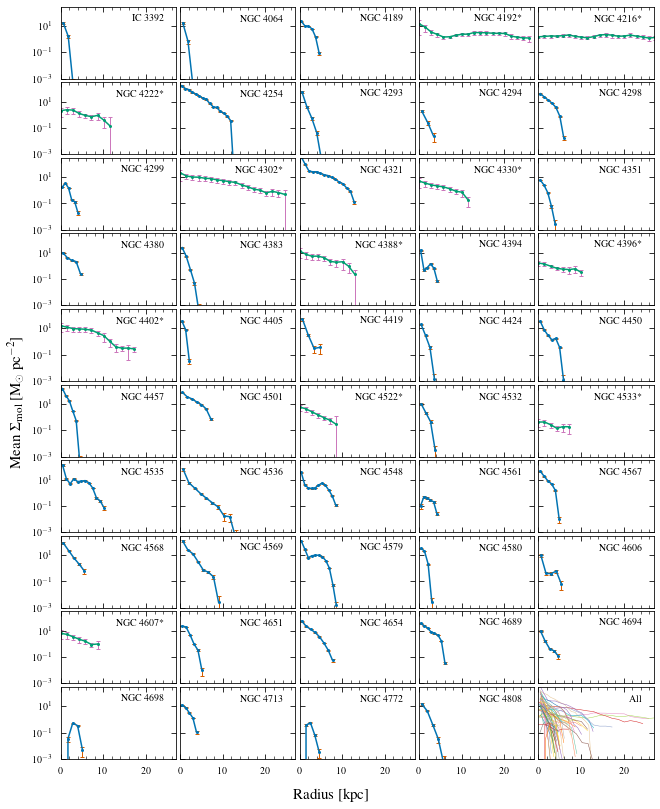

In [4]:
import re


def fix_aspect_ratio_semilogy(ax, aspect_ratio):
    """
    Set the aspect ratio of a plot.
    """
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xrange = xlim[1] - xlim[0]
    yrange = np.log10(ylim[1]) - np.log10(ylim[0])
    ax.set_aspect(aspect_ratio * xrange / yrange, adjustable="box")


#
# Plot 1 radial profile per subplot
#
# galaxies_to_plot = [
#     galaxy
#     for galaxy in galaxies
#     if galaxy not in ["NGC4216", "NGC4254", "NGC4321", "NGC4501", "NGC4535"]
# ]
galaxies_to_plot = galaxies

fig, axs = plt.subplots(nrows=10, ncols=5, figsize=(9, 11), sharex=True, sharey=True)
for ax, galname, i in zip(axs.flatten()[:-1], galaxies_to_plot, inclinations):
    is_high_i = i >= i_threshold
    galidx = galaxies.index(galname)
    if is_high_i:
        tmp_color = sns.color_palette("colorblind")[2]
        tmp_ecolor = sns.color_palette("colorblind")[4]
    else:
        tmp_color = sns.color_palette("colorblind")[0]
        tmp_ecolor = sns.color_palette("colorblind")[3]
    ebar = ax.errorbar(
        x=radius_kpc[galidx],
        y=radial_profiles[galidx].avg_data,
        yerr=radial_profiles[galidx].avg_data_err,
        fmt="-o",
        markersize=2,
        color=tmp_color,
        ecolor=tmp_ecolor,
        elinewidth=1,
        capsize=2,
    )
    ax.set_ylim(1e-3, 3e2)
    ax.set_xlim(0, 27)
    ax.semilogy()
    fix_aspect_ratio_semilogy(ax, 0.625)
    # Galaxy name in top right corner + add space between letters and numbers in galname
    high_i_str = "*" if is_high_i else ""
    ax.text(0.9, 0.8, re.sub(r"(\d+)", " \\1", galname) + high_i_str, c="k", ha="right", transform=ax.transAxes)
    ax.grid(False)
#
# Plot all radial profiles in 1 subplot
#
for galname in galaxies:
    galidx = galaxies.index(galname)
    axs[-1, -1].plot(
        radius_kpc[galidx], radial_profiles[galidx].avg_data, lw=0.5
    )
axs[-1, -1].text(0.9, 0.8, "All", c="k", ha="right", transform=axs[-1, -1].transAxes)
axs[-1, -1].set_ylim(1e-3, 3e2)
axs[-1, -1].set_xlim(0, 27)
axs[-1, -1].semilogy()
fix_aspect_ratio_semilogy(axs[-1, -1], 0.625)
axs[-1, -1].grid(False)
#
# Common x- and y-axis labels
#
# for ax in axs[-1, :]:
#     ax.set_xlabel("Radius [kpc]")
# for ax in axs[:, 0]:
#     ax.set_ylabel(r"$\Sigma_{\rm mol}$ [$\rm M_\odot\; pc^{-2}$]")
fig.text(0.5, 0.0, "Radius [kpc]", ha="center", fontsize=15)
fig.text(
    0.0,
    0.5,
    f"{avg_function.capitalize()} " + r"$\Sigma_{\rm mol}$ [$\rm M_\odot\; pc^{-2}$]",
    va="center",
    rotation="vertical",
    fontsize=15,
)
#
# fig.tight_layout(pad=0)
plt.subplots_adjust(left=0.08, right=1.0, bottom=0.05, top=1.0, wspace=0.007, hspace=0.05)
# fig.savefig("/arc/home/IsaacCheng/coop_f2021/galaxies/gas_densities/gas_density_i_corr_allVERTICO.pdf")
plt.show()

## Average uncertainty


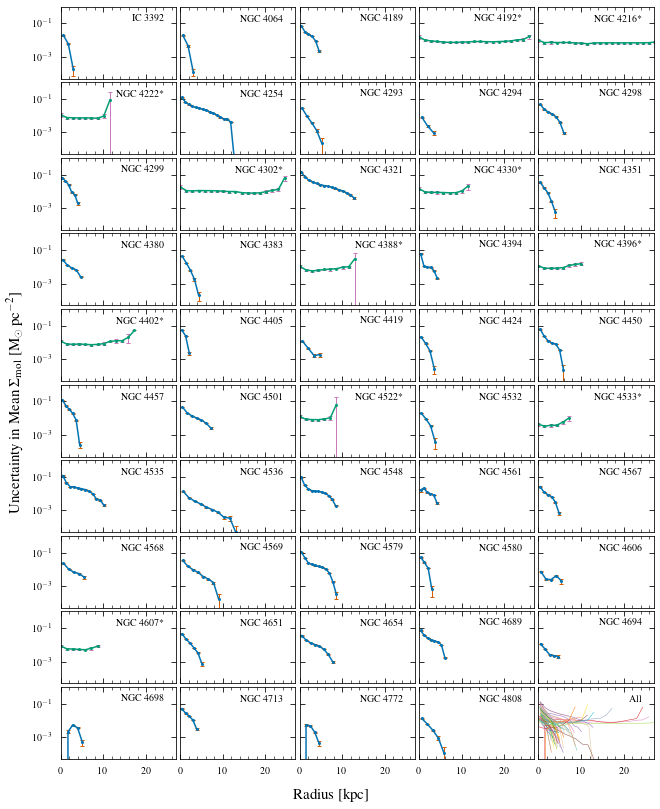

In [4]:
import re

# Uncertainty mosaic


def fix_aspect_ratio_semilogy(ax, aspect_ratio):
    """
    Set the aspect ratio of a plot.
    """
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xrange = xlim[1] - xlim[0]
    yrange = np.log10(ylim[1]) - np.log10(ylim[0])
    ax.set_aspect(aspect_ratio * xrange / yrange, adjustable="box")


#
# Plot 1 radial profile per subplot
#
# galaxies_to_plot = [
#     galaxy
#     for galaxy in galaxies
#     if galaxy not in ["NGC4216", "NGC4254", "NGC4321", "NGC4501", "NGC4535"]
# ]
galaxies_to_plot = galaxies

fig, axs = plt.subplots(nrows=10, ncols=5, figsize=(9, 11), sharex=True, sharey=True)
for ax, galname, i in zip(axs.flatten()[:-1], galaxies_to_plot, inclinations):
    is_high_i = i >= i_threshold
    galidx = galaxies.index(galname)
    if is_high_i:
        tmp_color = sns.color_palette("colorblind")[2]
        tmp_ecolor = sns.color_palette("colorblind")[4]
    else:
        tmp_color = sns.color_palette("colorblind")[0]
        tmp_ecolor = sns.color_palette("colorblind")[3]
    ebar = ax.errorbar(
        x=radius_kpc[galidx],
        y=radial_profiles[galidx].avg_noise,
        yerr=radial_profiles[galidx].avg_noise_err,
        fmt="-o",
        markersize=2,
        color=tmp_color,
        ecolor=tmp_ecolor,
        elinewidth=1,
        capsize=2,
    )
    ax.set_ylim(5e-5, 1)
    ax.set_xlim(0, 27)
    ax.semilogy()
    fix_aspect_ratio_semilogy(ax, 0.625)
    # Galaxy name in top right corner + add space between letters and numbers in galname
    high_i_str = "*" if is_high_i else ""
    ax.text(0.9, 0.8, re.sub(r"(\d+)", " \\1", galname) + high_i_str, c="k", ha="right", transform=ax.transAxes)
    ax.grid(False)
#
# Plot all radial profiles in 1 subplot
#
for galname in galaxies:
    galidx = galaxies.index(galname)
    axs[-1, -1].plot(
        radius_kpc[galidx], radial_profiles[galidx].avg_noise, lw=0.5
    )
axs[-1, -1].text(0.9, 0.8, "All", c="k", ha="right", transform=axs[-1, -1].transAxes)
axs[-1, -1].set_ylim(5e-5, 1)
axs[-1, -1].set_xlim(0, 27)
axs[-1, -1].semilogy()
fix_aspect_ratio_semilogy(axs[-1, -1], 0.625)
axs[-1, -1].grid(False)
#
# Common x- and y-axis labels
#
# for ax in axs[-1, :]:
#     ax.set_xlabel("Radius [kpc]")
# for ax in axs[:, 0]:
#     ax.set_ylabel(r"$\Sigma_{\rm mol}$ [$\rm M_\odot\; pc^{-2}$]")
fig.text(0.5, 0.0, "Radius [kpc]", ha="center", fontsize=15)
fig.text(
    0.0,
    0.5,
    f"Uncertainty in {avg_function.capitalize()} " + r"$\Sigma_{\rm mol}$ [$\rm M_\odot\; pc^{-2}$]",
    va="center",
    rotation="vertical",
    fontsize=15,
)
#
# fig.tight_layout(pad=0)
plt.subplots_adjust(left=0.08, right=1.0, bottom=0.05, top=1.0, wspace=0.007, hspace=0.05)
# fig.savefig("/arc/home/IsaacCheng/coop_f2021/galaxies/gas_densities/gas_density_unc_i_corr_allVERTICO.pdf")
plt.show()

In [15]:
maxyval = np.nanmax([np.nanmax(rp.avg_data) for rp in radial_profiles])
minyval = np.nanmin([np.nanmin(rp.avg_data[rp.avg_data > 0]) for rp in radial_profiles])
print(maxyval)
print(minyval)
print(np.nanmax([np.nanmax(rkpc_vals) for rkpc_vals in radius_kpc]))
print([np.nanmax(rkpc_vals) for rkpc_vals in radius_kpc])


331.76120356882797
1.8763276527570922e-05
28.797932659127465
[2.9407196302593674, 3.0776234819133585, 4.593326120868104, 25.90507206711006, 28.797932659127465, 11.519173063697064, 12.658484711932292, 5.182923854780349, 3.4282484760534104, 5.96408312417804, 4.019869465174108, 24.478242759631698, 12.82969987981151, 11.519173063581873, 3.960576321503019, 4.652948221826833, 4.332444506568803, 12.959069696482953, 4.299854581254693, 10.079276430549472, 17.278759595469566, 2.1595123523871083, 4.799547866445977, 3.6189597281700485, 5.899005148618903, 4.430877075906031, 7.198475774538563, 8.639379797641478, 3.805821227027273, 7.199483164784747, 10.121472821315182, 13.027344209034222, 8.458947144996102, 4.214019554316323, 4.888690594035032, 5.5397222664092265, 9.019822744577036, 8.637014253099549, 3.0233172933697667, 5.411893646689937, 8.639379798218588, 5.104256582924807, 7.754913703119167, 6.082701601190339, 4.7283453462024605, 5.079923641864879, 3.8527544717492423, 4.581723030074779, 5.828041

# Make individual radial profile plots of all galaxies


## Just testing plots

Manually do not include bad for NGC 4294 (for beamer)


In [5]:
# Parameters & values

galaxies = [
    "IC3392", "NGC4064", "NGC4189", "NGC4192", "NGC4216", "NGC4222", "NGC4254",
    "NGC4293", "NGC4294", "NGC4298", "NGC4299", "NGC4302", "NGC4321", "NGC4330",
    "NGC4351", "NGC4380", "NGC4383", "NGC4388", "NGC4394", "NGC4396", "NGC4402",
    "NGC4405", "NGC4419", "NGC4424", "NGC4450", "NGC4457", "NGC4501", "NGC4522",
    "NGC4532", "NGC4533", "NGC4535", "NGC4536", "NGC4548", "NGC4561", "NGC4567",
    "NGC4568", "NGC4569", "NGC4579", "NGC4580", "NGC4606", "NGC4607", "NGC4651",
    "NGC4654", "NGC4689", "NGC4694", "NGC4698", "NGC4713", "NGC4772", "NGC4808",
]  # 49 galaxies

inclinations = [
    68, 70, 42, 83, 90, 90, 39, 67, 74, 52, 14, 90, 32, 90, 48, 61, 56, 83, 32, 83, 80,
    46, 74, 61, 51, 37, 65, 82, 64, 80, 48, 74, 37, 28, 49, 70, 69, 40, 46, 69, 90, 53,
    61, 38, 62, 66, 45, 60, 72
]  # degrees

position_angles = [
    219, 150, 70, 333, 20, 238, 243, 239, 151, 132, 128, 356, 280, 238, 251, 158, 17, 271,
    312, 304, 270, 18, 131, 274, 170, 256, 320, 35, 159, 342, 12, 118, 318, 60, 251, 211,
    203, 273, 337, 38, 2, 75, 300, 341, 323, 347, 89, 325, 127
]  # degrees

ALPHA_CO = 4.35  # M_sun/pc^2 per (K km/s)
R_21 = 0.8  # dimensionless. CO(2-1)/CO(1-0) ratio
# 
# Parameters
# 
I_THRESHOLD = 80  # degrees
I_REPLACEMENT = 80  # degrees
# SNR_CUTOFF = 0  # fit until no gas detected. some pathological galaxies do not have CO in centre
MAX_SNR_ANNULI = 40
MIN_WIDTH = None  # get from header
# INCLUDE_BAD = False  # changes depending if low- or high-inclination galaxy
PHOTUTILS_METHOD = "exact"
AVG_FUNCTION = "mean"
IS_RADIO = True
HIGH_I_HEIGHT = None  # extend high-i rectangles to image borders
BOOTSTRAP_ERRS = True
BOOTSTRAP_SEED = 2021
# 
# Calculate radial profiles of all the galaxies
# 
for galaxy, i, pa in zip(galaxies, inclinations, position_angles):
    if galaxy != "NGC4294":
        continue
    print("\nProcessing", galaxy)
    # Load data
    if galaxy == "NGC4321":  # no 9 arcsec data since native is 10 arcsec
        Ico_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3.1/native/{galaxy}/{galaxy}_7m+tp_co21_pbcorr_round_mom0_Kkms-1.fits"
        Ico_unc_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3.1/native/{galaxy}/{galaxy}_7m+tp_co21_pbcorr_round_mom0_unc.fits"
    else:
        Ico_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/{galaxy}/{galaxy}_7m+tp_co21_pbcorr_9as_round_mom0_Kkms-1.fits"
        Ico_unc_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/{galaxy}/{galaxy}_7m+tp_co21_pbcorr_9as_round_mom0_unc.fits"
    Ico_data, gal_header = fits.getdata(Ico_path, header=True)
    Ico_unc = fits.getdata(Ico_unc_path)  # uncertainty
    gal_wcs = WCS(gal_header)
    # Set parameters
    centre = gal_wcs.pixel_to_world(Ico_data.shape[1] / 2, Ico_data.shape[0] / 2)
    include_bad = False # if i < I_THRESHOLD else False  # only include NaNs if low-i galaxy
    if galaxy == "NGC4698" or galaxy == "NGC4772":
        snr_cutoff = None
        n_annuli = 5
    else:
        snr_cutoff = 0  # fit until no gas detected
        n_annuli = None
    # Mask background
    Ico_mask = (~np.isfinite(Ico_unc)) | (Ico_unc <= 0)
    Ico_data[Ico_mask] = np.nan
    Ico_unc[Ico_mask] = np.nan
    # Convert to gas density (M_sun/pc^2)
    gas_density_i_uncorr = ALPHA_CO / R_21 * Ico_data
    gas_density_unc_i_uncorr = ALPHA_CO / R_21 * Ico_unc
    # Make radial profile
    galaxy_rp = RadialProfile(
        gas_density_i_uncorr, centre, i, pa, noise=gas_density_unc_i_uncorr
    )
    galaxy_rp = galaxy_rp.calc_radial_profile(
        i_threshold=I_THRESHOLD,
        n_annuli=n_annuli,
        snr_cutoff=snr_cutoff,
        max_snr_annuli=MAX_SNR_ANNULI,
        min_width=MIN_WIDTH,
        header=gal_header,
        include_bad=include_bad,
        method=PHOTUTILS_METHOD,
        func=AVG_FUNCTION,
        is_radio=IS_RADIO,
        high_i_height=HIGH_I_HEIGHT,
        bootstrap_errs=BOOTSTRAP_ERRS,
        bootstrap_seed=BOOTSTRAP_SEED,
    )
    galaxy_rp = galaxy_rp.correct_for_i(i_replacement=I_REPLACEMENT)



Processing NGC4294
Getting minimum width from radio beam size
Min width/beam size (pixels): 4.50000000020304
Info: Fitting annuli according to snr_cutoff. Warning messages (e.g., invalid values, degrees of freedom <= 0, etc.) can safely be ignored
Iter 1: average SNR = 227.05383203282304
Iter 2: average SNR = 108.17102165832826
Iter 3: average SNR = 24.727468283797062
Stopped creating ellipses/annuli after 3 iterations
Average SNR of most recent successful fit: 24.727468283797062
Average SNR of next annulus: nan


/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:607: RuntimeWarning: invalid value encountered in double_scalars
  avg_signal = avg_signal / np.nansum(signal_area_mask)
/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:613: RuntimeWarning: invalid value encountered in double_scalars
  avg_noise = np.sqrt(avg_noise) / np.nansum(noise_area_mask)
/opt/conda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


/opt/conda/lib/python3.8/contextlib.py:113: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  return next(self.gen)


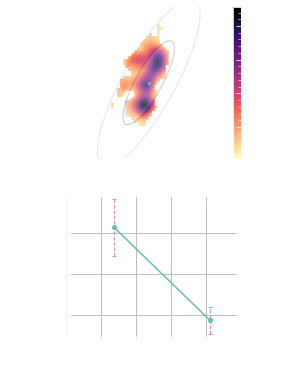

In [7]:
# 
# Viewing 1 by 1
# 
%matplotlib inline
import re

GALAXY_TO_PLOT = "NGC4294"
GALDIST = 16.5 * u.Mpc
galidx = galaxies.index(GALAXY_TO_PLOT)
# galaxy_rp = radial_profiles[galidx]
galaxy_wcs = WCS(galaxy_rp.rp_options["header"])

with plt.style.context("/arc/home/IsaacCheng/coop_f2021/stylesheets/beamer.mplstyle"):
    with plt.rc_context({"font.size" : 10}):  # temporaily decrease fontsizes
        fig = plt.figure(figsize=mpl.figure.figaspect(1.5))
        # 
        # Plot data
        # 
        ax1 = fig.add_subplot(2, 1, 1, projection=galaxy_wcs)
        img1 = ax1.imshow(galaxy_rp.data, cmap="magma_r")
        cbar1 = fig.colorbar(img1, fraction=0.045)
        cbar1.set_label(r"$\Sigma_{\rm mol}$ [$\rm M_\odot\; pc^{-2}$]")
        # 
        # Plot annuli
        # 
        ax1.plot(*galaxy_wcs.world_to_pixel(centers[galidx]), marker="o", color="C0", markersize=2)  # mark centre
        # pu.add_annuli_RadialProfile(ax1, galaxy_rp, ls="-", edgecolor="k", fc="w", lw=1, zorder=2, alpha_coeff=0.2)
        pu.add_annuli(ax1, galaxy_rp.annuli[:-1], ls="-", edgecolor="k", fc="w", lw=1, zorder=2, alpha_coeff=0.2)
        #
        # Add beam size and scalebar
        #
        pu.add_scalebeam(ax1, galaxy_rp.rp_options["header"], ec="w")
        pu.add_scalebar(ax1, galaxy_wcs, dist=GALDIST, color="w")
        #
        # Other parameters
        # 
        ax1.set_aspect("equal")
        ax1.grid(False)
        ax1.set_xlabel("RA (J2000)")
        ax1.set_ylabel("Dec (J2000)")
        ax1.set_xlim(0, galaxy_rp.data.shape[1])
        ax1.set_ylim(0, galaxy_rp.data.shape[0])
        #
        # Plot radial profile
        # 
        ax2 = fig.add_subplot(2, 1, 2)
        ebar2 = ax2.errorbar(
            # x=radius_kpc[galidx],
            # y=galaxy_rp.avg_data,
            # yerr=galaxy_rp.avg_data_err,  # uncertainty in the mean/median from bootstrapping
            x=radius_kpc[galidx][:-1],
            y=galaxy_rp.avg_data[:-1],
            yerr=galaxy_rp.avg_data_err[:-1],  # uncertainty in the mean/median from bootstrapping
            fmt="-o",
            markersize=4,
            color="C0",
            ecolor="C3",
            elinewidth=1,
            capsize=2,
        )
        ebar2[-1][0].set_linestyle("--")
        # 
        # Add name of galaxy
        # 
        high_i_str = "*" if inclinations[galidx] >= i_threshold else ""
        ax2.text(
            0.9,
            0.9,
            re.sub(r"(\d+)", " \\1", GALAXY_TO_PLOT) + high_i_str,
            c="w",
            ha="right",
            transform=ax2.transAxes,
        )
        # 
        # Other parameters
        # 
        # ax2.semilogy()
        ax2.set_xlim(left=0)
        ax2.set_xticks(np.arange(0, 3, 0.5))
        ax2.set_xlabel("Radius [kpc]")
        ax2.set_ylabel(
            f"{avg_function.capitalize()} " + r"$\Sigma_{\rm mol}$ [$\rm M_\odot\; pc^{-2}$]"
        )
        pu.set_aspect(ax2, 0.85, logy=False)
        # 
        fig.tight_layout(pad=3.25)
        # fig.savefig(f"{GALAXY_TO_PLOT}_gasDensity_radProf_2annuli_i_corr_noIncludeBad_beamer.pdf")
        plt.show()

In [8]:
gal_drp = galaxy_rp.directional_radial_profile(
    angle=None,  # take direction to be along galaxy's major axis
    bootstrap_errs=True,
    bootstrap_seed=2021,
    results_to_1d=True,  # easier to plot radial profile this way
)

In [16]:
sns.color_palette("vlag")

[(0.4305964, 0.56276546, 0.74956387),
 (0.66563334, 0.72242871, 0.81414642),
 (0.89443865, 0.89721298, 0.9202854),
 (0.94742246, 0.87278899, 0.86691076),
 (0.85164413, 0.65142189, 0.64145983),
 (0.76133542, 0.43410655, 0.42592523)]

/opt/conda/lib/python3.8/contextlib.py:113: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  return next(self.gen)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


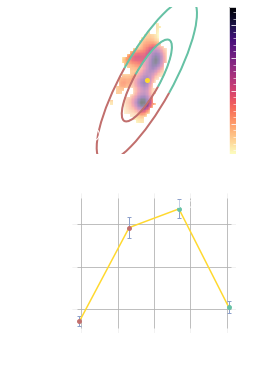

In [21]:
from matplotlib.patches import Arc
drp_radii_kpc = -np.copy(radius_kpc[galidx])[::-1]
drp_radii_kpc = np.append(drp_radii_kpc, np.copy(radius_kpc[galidx]))
# 
# Plot DIRECTIONAL PROFILE data
#
with plt.style.context("/arc/home/IsaacCheng/coop_f2021/stylesheets/beamer.mplstyle"):
    with plt.rc_context({"font.size" : 10}):  # temporaily decrease fontsizes
        fig = plt.figure(figsize=mpl.figure.figaspect(1.5))
        ax1 = fig.add_subplot(2, 1, 1, projection=gal_wcs)
        positive_color = "C0"
        negative_color = sns.color_palette("vlag")[5]
        #
        # Plot data
        #
        img1 = ax1.imshow(gal_drp.data, cmap="magma_r")
        cbar1 = fig.colorbar(img1, fraction=0.045)
        cbar1.set_label(r"$\Sigma_{\rm mol}$ [$\rm M_\odot\; pc^{-2}$]")
        # Mark centre
        ax1.plot(*gal_wcs.world_to_pixel(centers[galidx]), marker="o", color="C5", markersize=4)
        # Add annuli
        pu.add_annuli(
            ax1, gal_drp.annuli[:-1], alpha_coeff=0.4,
            ls="-", edgecolor="k", fc="w", lw=1, zorder=2
        )
        # Add annuli from outer to inner
        annuli = np.hstack((gal_drp.annuli[1::-1], gal_drp.annuli[:-1]))
        for num, annulus in enumerate(annuli):
            try:
                # EllipticalAnnulus attributes. N.B. height and width are switched from "normal"
                height = annulus.b_out
                width = annulus.a_out
            except AttributeError:
                # EllipticalAperture attributes. N.B. height and width are switched from "normal"
                height = annulus.b
                width = annulus.a
            if num >= len(annuli) / 2:
                # Positive radii annuli
                edgecolor = positive_color
                arcangle = (np.rad2deg(annulus.theta) + 180) % 360.0
            else:
                # Negative radii annuli
                edgecolor = negative_color
                arcangle = np.rad2deg(annulus.theta) % 360.0
            arc = Arc(
                xy=annulus.positions,
                width=width * 2,  # full major/minor axis
                height=height * 2,  # full major/minor axis
                angle=arcangle,
                theta1=-90,
                theta2=90,
                ls="-",
                edgecolor=edgecolor,
                alpha=1,
                lw=2,
                zorder=2,
            )
            ax1.add_patch(arc)
        # Add scalebar
        pu.add_scalebar(ax1, gal_wcs, dist=GALDIST, color="w")
        pu.add_scalebeam(ax1, gal_drp.rp_options["header"], ec="w")
        ax1.set_xlim(0, gal_drp.data.shape[1])
        ax1.set_ylim(0, gal_drp.data.shape[0])
        ax1.set_xlabel("RA (J2000)")
        ax1.set_ylabel("Dec (J2000)")
        ax1.grid(False)
        ax1.set_aspect("equal")
        #
        ax2 = fig.add_subplot(2, 1, 2)
        # Plot negative radii data
        ax2.scatter(
            x=drp_radii_kpc[drp_radii_kpc < 0][1:],
            y=gal_drp.drp_results["avg_data"][drp_radii_kpc < 0][1:],
            c=negative_color,
            s=15,
            zorder=3,
        )
        # Plot positive radii data
        ax2.scatter(
            x=drp_radii_kpc[drp_radii_kpc > 0][:-1],
            y=gal_drp.drp_results["avg_data"][drp_radii_kpc > 0][:-1],
            c=positive_color,
            s=15,
            zorder=3,
        )
        # Plot errorbars
        ebar2 = ax2.errorbar(
            x=drp_radii_kpc[1:-1],
            y=gal_drp.drp_results["avg_data"][1:-1],
            yerr=gal_drp.drp_results["avg_data_err"][1:-1],  # uncertainty from bootstrapping
            fmt="-",
            color="C5",
            ecolor="C2",
            elinewidth=1,
            capsize=2,
        )
        # 
        # Add name of galaxy
        # 
        high_i_str = "*" if inclinations[galidx] >= i_threshold else ""
        ax2.text(
            0.9,
            0.9,
            re.sub(r"(\d+)", " \\1", GALAXY_TO_PLOT) + high_i_str,
            c="w",
            ha="right",
            transform=ax2.transAxes,
        )
        ax2.set_xlabel("Radius [kpc]")
        ax2.set_ylabel(
            gal_drp.rp_options["func"].capitalize()
            + r" $\Sigma_{\rm mol}$ [$\rm M_\odot\; pc^{-2}$]"
        )
        pu.set_aspect(ax2, 0.85, logx=False, logy=False)
        #
        fig.tight_layout(pad=3.5)
        # fig.savefig(f"{GALAXY_TO_PLOT}_gasDensity_directionalRadProf_2annuli_i_corr_noIncludeBad_beamer.pdf")
        plt.show()

## Average data


In [ ]:
# 
# Radial profile plots of all galaxies
# 
import re

GALDIST = 16.5 * u.Mpc

for galaxy in galaxies:
    galidx = galaxies.index(galaxy)
    galaxy_rp = radial_profiles[galidx]
    galaxy_wcs = WCS(galaxy_rp.rp_options["header"])

    fig = plt.figure(figsize=mpl.figure.figaspect(1.5))
    # 
    # Plot data
    # 
    ax1 = fig.add_subplot(2, 1, 1, projection=galaxy_wcs)
    img1 = ax1.imshow(galaxy_rp.data, cmap="magma_r")
    cbar1 = fig.colorbar(img1, fraction=0.045)
    cbar1.set_label(r"$\Sigma_{\rm mol}$ [$\rm M_\odot\; pc^{-2}$]")
    # 
    # Plot annuli
    # 
    ax1.plot(*galaxy_wcs.world_to_pixel(centers[galidx]), "co", markersize=2)  # mark centre
    pu.add_annuli_RadialProfile(ax1, galaxy_rp)
    #
    # Add beam size and scalebar
    #
    pu.add_scalebeam(ax1, galaxy_rp.rp_options["header"])
    pu.add_scalebar(ax1, galaxy_wcs, dist=GALDIST)
    #
    # Other parameters
    # 
    ax1.set_aspect("equal")
    ax1.grid(False)
    ax1.set_xlabel("RA (J2000)")
    ax1.set_ylabel("Dec (J2000)")
    ax1.set_xlim(0, galaxy_rp.data.shape[1])
    ax1.set_ylim(0, galaxy_rp.data.shape[0])
    #
    # Plot radial profile
    # 
    ax2 = fig.add_subplot(2, 1, 2)
    ebar2 = ax2.errorbar(
        x=radius_kpc[galidx],
        y=galaxy_rp.avg_data,
        yerr=galaxy_rp.avg_data_err,  # uncertainty in the mean/median from bootstrapping
        fmt="-o",
        markersize=4,
        color="k",
        ecolor="r",
        elinewidth=1,
        capsize=2,
    )
    ebar2[-1][0].set_linestyle("--")
    # 
    # Add name of galaxy
    # 
    high_i_str = "*" if inclinations[galidx] >= i_threshold else ""
    ax2.text(
        0.9,
        0.9,
        re.sub(r"(\d+)", " \\1", galaxy) + high_i_str,
        c="k",
        ha="right",
        transform=ax2.transAxes,
    )
    # 
    # Other parameters
    # 
    ax2.semilogy()
    ax2.set_xlim(left=0)
    ax2.set_xlabel("Radius [kpc]")
    ax2.set_ylabel(
        f"{avg_function.capitalize()} " + r"$\Sigma_{\rm mol}$ [$\rm M_\odot\; pc^{-2}$]"
    )
    # 
    fig.tight_layout(pad=3.25)
    fig.savefig(f"{galaxy}_gasDensity_radProf_i_corr.pdf")
    plt.close()

print("Done!")

## Average uncertainty


In [6]:
# 
# Radial profile plots of uncertainties for all galaxies
# 
import re

GALDIST = 16.5 * u.Mpc

for galaxy in galaxies:
    galidx = galaxies.index(galaxy)
    galaxy_rp = radial_profiles[galidx]
    galaxy_wcs = WCS(galaxy_rp.rp_options["header"])

    fig = plt.figure(figsize=mpl.figure.figaspect(1.5))
    # 
    # Plot data
    # 
    ax1 = fig.add_subplot(2, 1, 1, projection=galaxy_wcs)
    img1 = ax1.imshow(galaxy_rp.noise, cmap="magma_r")
    cbar1 = fig.colorbar(img1, fraction=0.045)
    cbar1.set_label(r"$\Sigma_{\rm mol}$ Uncertainty [$\rm M_\odot\; pc^{-2}$]")
    # 
    # Plot annuli
    # 
    ax1.plot(*galaxy_wcs.world_to_pixel(centers[galidx]), "co", markersize=2)  # mark centre
    pu.add_annuli_RadialProfile(ax1, galaxy_rp)
    #
    # Add beam size and scalebar
    #
    pu.add_scalebeam(ax1, galaxy_rp.rp_options["header"])
    pu.add_scalebar(ax1, galaxy_wcs, dist=GALDIST)
    #
    # Other parameters
    # 
    ax1.set_aspect("equal")
    ax1.grid(False)
    ax1.set_xlabel("RA (J2000)")
    ax1.set_ylabel("Dec (J2000)")
    ax1.set_xlim(0, galaxy_rp.noise.shape[1])
    ax1.set_ylim(0, galaxy_rp.noise.shape[0])
    #
    # Plot radial profile
    # 
    ax2 = fig.add_subplot(2, 1, 2)
    ebar2 = ax2.errorbar(
        x=radius_kpc[galidx],
        y=galaxy_rp.avg_noise,
        yerr=galaxy_rp.avg_noise_err,  # uncertainty in the mean/median from bootstrapping
        fmt="-o",
        markersize=4,
        color="k",
        ecolor="r",
        elinewidth=1,
        capsize=2,
    )
    ebar2[-1][0].set_linestyle("--")
    # 
    # Add name of galaxy
    # 
    high_i_str = "*" if inclinations[galidx] >= i_threshold else ""
    ax2.text(
        0.9,
        0.9,
        re.sub(r"(\d+)", " \\1", galaxy) + high_i_str,
        c="k",
        ha="right",
        transform=ax2.transAxes,
    )
    # 
    # Other parameters
    # 
    ax2.semilogy()
    ax2.set_xlim(left=0)
    ax2.set_xlabel("Radius [kpc]")
    ax2.set_ylabel(
        f"Uncertainty in {avg_function.capitalize()} " + r"$\Sigma_{\rm mol}$ [$\rm M_\odot\; pc^{-2}$]"
    )
    # 
    fig.tight_layout(pad=3.25)
    fig.savefig(f"{galaxy}_gasDensity_unc_radProf_i_corr.pdf")
    plt.close()

print("Done!")

Done!


# Radial Profile Mosaic of just NGVS-VERTICO Sample

36 galaxies ordered by decreasing mean/median stellar mass in image (stellar masses estimated from lookup table)


In [2]:
NGVS_GALAXIES = np.array([
    "IC3392",
    # "NGC4189",  # ignored flag map, but bad results
    "NGC4192",
    "NGC4216",  # has unflagged foreground star
    "NGC4222",
    "NGC4254",
    "NGC4294",
    "NGC4298",
    "NGC4299",
    "NGC4302",
    "NGC4321",
    "NGC4330",
    "NGC4351",
    "NGC4380",
    "NGC4383",
    "NGC4388",
    "NGC4396",
    "NGC4402",
    "NGC4405",
    "NGC4419",
    "NGC4424",
    "NGC4450",
    "NGC4501",
    "NGC4522",
    "NGC4532",
    "NGC4535",
    "NGC4548",
    "NGC4567",
    "NGC4568",
    "NGC4569",
    "NGC4579",
    "NGC4580",
    # "NGC4606",  # flag map too intrusive
    "NGC4607",
    "NGC4651",
    "NGC4654",
    "NGC4689",
    "NGC4694",
])
NGVS_INCLINATIONS = np.array([
    68,
    # 42,  # ignored flag map, but bad results
    83,
    90,  # has unflagged foreground star
    90,
    39,
    74,
    52,
    14,
    90,
    32,
    90,
    48,
    61,
    56,
    83,
    83,
    80,
    46,
    74,
    61,
    51,
    65,
    82,
    64,
    48,
    37,
    49,
    70,
    69,
    40,
    46,
    # 69,  # flag map too intrusive
    90,
    53,
    61,
    38,
    62,
])  # degrees
NGVS_POSITION_ANGLES = np.array([
    219,
    # 70,  # ignored flag map, but bad results
    333,
    20,  # has unflagged foreground star
    238,
    243,
    151,
    132,
    128,
    356,
    280,
    238,
    251,
    158,
    17,
    271,
    304,
    270,
    18,
    131,
    274,
    170,
    320,
    35,
    159,
    12,
    318,
    251,
    211,
    203,
    273,
    337,
    # 38,  # flag map too intrusive
    2,
    75,
    300,
    341,
    323,
])  # degrees
# ! WARNING: DO NOT UNCOMMENT NGC4189 OR NGC4606 IF USING THIS AS THEY WERE NOT CONSIDERED !
NGVS_DECR_NAIVE_MEAN_M_DENSITY_IDX = np.array(
    [
        18,
        21,
        27,
        20,
        28,
        29,
        30,
        26,
        0,
        2,
        25,
        32,
        17,
        9,
        1,
        35,
        14,
        19,
        8,
        24,
        12,
        16,
        6,
        34,
        4,
        31,
        33,
        22,
        13,
        10,
        5,
        3,
        23,
        7,
        11,
        15,
    ]
)  # simply took nanmean of image
# ! WARNING: DO NOT UNCOMMENT NGC4189 OR NGC4606 IF USING THIS AS THEY WERE NOT CONSIDERED !
NGVS_DECR_NAIVE_MEDIAN_M_DENSITY_IDX = np.array(
    [
        21,
        27,
        30,
        26,
        20,
        0,
        29,
        9,
        17,
        25,
        28,
        24,
        34,
        18,
        12,
        35,
        19,
        32,
        6,
        10,
        33,
        4,
        5,
        1,
        2,
        11,
        14,
        16,
        13,
        22,
        7,
        8,
        3,
        15,
        23,
        31,
    ]
)  # simply took nanmedian of image
# ! WARNING: DO NOT UNCOMMENT NGC4189 OR NGC4606 IF USING THIS AS THEY WERE NOT CONSIDERED !
NGVS_DECR_MEAN_M_DENSITY_IDX = np.array(
    [
        18,
        21,
        27,
        29,
        16,
        28,
        14,
        0,
        30,
        35,
        26,
        12,
        17,
        32,
        25,
        9,
        34,
        33,
        19,
        24,
        20,
        2,
        4,
        11,
        22,
        3,
        6,
        1,
        8,
        5,
        23,
        7,
        10,
        31,
        15,
        13,
    ]
)  # only considered finite SNRs >= 30 and treated each Voronoi bin as 1 pixel
# ! WARNING: DO NOT UNCOMMENT NGC4189 OR NGC4606 IF USING THIS AS THEY WERE NOT CONSIDERED !
NGVS_DECR_MEDIAN_M_DENSITY_IDX = np.array(
    [
        21,
        0,
        18,
        30,
        27,
        29,
        26,
        14,
        35,
        12,
        16,
        28,
        17,
        34,
        9,
        19,
        32,
        25,
        11,
        24,
        20,
        33,
        5,
        4,
        7,
        6,
        22,
        10,
        3,
        2,
        8,
        15,
        13,
        1,
        23,
        31,
    ]
)  # only considered finite SNRs >= 30 and treated each Voronoi bin as 1 pixel

In [3]:
# 
# Load data
# 
rp_infile = "/arc/home/IsaacCheng/coop_f2021/galaxies/gas_densities/gas_density_i_corr_allVERTICO.pkl"
with open(rp_infile, "rb") as f:
    file = dill.load(f)
    galaxies = file["galaxies"]
    inclinations = file["inclinations"]
    position_angles = file["position_angles"]
    centers = file["centers"]
    i_threshold = file["i_threshold"]
    i_replacement = file["i_replacement"]
    n_annulis = file["n_annulis"]
    snr_cutoffs = file["snr_cutoffs"]
    max_snr_annuli = file["max_snr_annuli"]
    min_width = file["min_width"]
    include_bads = file["include_bads"]
    photutils_method = file["photutils_method"]
    avg_function = file["avg_function"]
    is_radio = file["is_radio"]
    high_i_height = file["high_i_height"]
    bootstrap_errs = file["bootstrap_errs"]
    bootstrap_seed = file["bootstrap_seed"]
    radial_profiles = file["radial_profiles"]
# Make dist
GALDIST = 16.5 * u.Mpc
radius_kpc = []
for galname in galaxies:
    galidx = galaxies.index(galname)
    gal_wcs = WCS(radial_profiles[galidx].rp_options["header"])
    px_to_kpc = fu.calc_pc_per_px(gal_wcs, GALDIST)[0][0] / 1000
    radius_kpc.append(radial_profiles[galidx].radii * px_to_kpc)

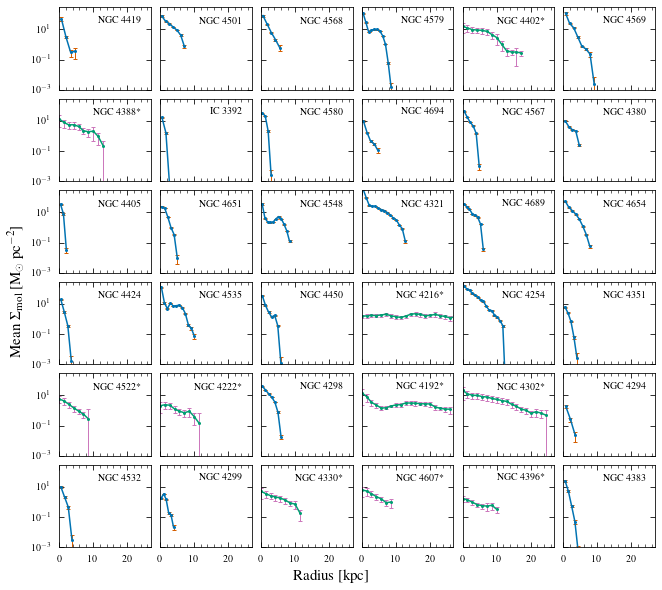

In [7]:
import re


def fix_aspect_ratio_semilogy(ax, aspect_ratio):
    """
    Set the aspect ratio of a plot.
    """
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xrange = xlim[1] - xlim[0]
    yrange = np.log10(ylim[1]) - np.log10(ylim[0])
    ax.set_aspect(aspect_ratio * xrange / yrange, adjustable="box")


#
# Plot 1 radial profile per subplot
#
fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(9, 8), sharex=True, sharey=True)
for ax, galname, i in zip(axs.flatten(), NGVS_GALAXIES[NGVS_DECR_MEAN_M_DENSITY_IDX], NGVS_INCLINATIONS[NGVS_DECR_MEAN_M_DENSITY_IDX]):
    is_high_i = i >= i_threshold
    galidx = galaxies.index(galname)
    if is_high_i:
        tmp_color = sns.color_palette("colorblind")[2]
        tmp_ecolor = sns.color_palette("colorblind")[4]
    else:
        tmp_color = sns.color_palette("colorblind")[0]
        tmp_ecolor = sns.color_palette("colorblind")[3]
    ebar = ax.errorbar(
        x=radius_kpc[galidx],
        y=radial_profiles[galidx].avg_data,
        yerr=radial_profiles[galidx].avg_data_err,
        fmt="-o",
        markersize=2,
        color=tmp_color,
        ecolor=tmp_ecolor,
        elinewidth=1,
        capsize=2,
    )
    ax.set_ylim(1e-3, 3e2)
    ax.set_xlim(0, 27)
    ax.semilogy()
    fix_aspect_ratio_semilogy(ax, 0.9)
    # Galaxy name in top right corner + add space between letters and numbers in galname
    high_i_str = "*" if is_high_i else ""
    ax.text(0.9, 0.8, re.sub(r"(\d+)", " \\1", galname) + high_i_str, c="k", ha="right", transform=ax.transAxes)
    ax.grid(False)
# #
# # Plot all radial profiles in 1 subplot
# #
# for galname in galaxies:
#     galidx = galaxies.index(galname)
#     axs[-1, -1].plot(
#         radius_kpc[galidx], radial_profiles[galidx].avg_data, lw=0.5
#     )
# axs[-1, -1].text(0.9, 0.8, "All", c="k", ha="right", transform=axs[-1, -1].transAxes)
# axs[-1, -1].set_ylim(1e-3, 3e2)
# axs[-1, -1].set_xlim(0, 27)
# axs[-1, -1].semilogy()
# fix_aspect_ratio_semilogy(axs[-1, -1], 0.625)
# axs[-1, -1].grid(False)
#
# Common x- and y-axis labels
#
# for ax in axs[-1, :]:
#     ax.set_xlabel("Radius [kpc]")
# for ax in axs[:, 0]:
#     ax.set_ylabel(r"$\Sigma_{\rm mol}$ [$\rm M_\odot\; pc^{-2}$]")
fig.text(0.5, 0.0, "Radius [kpc]", ha="center", fontsize=15)
fig.text(
    0.0,
    0.5,
    f"{avg_function.capitalize()} " + r"$\Sigma_{\rm mol}$ [$\rm M_\odot\; pc^{-2}$]",
    va="center",
    rotation="vertical",
    fontsize=15,
)
#
plt.subplots_adjust(left=0.08, right=1.0, bottom=0.05, top=1.0, wspace=0.1, hspace=0.02)
# fig.savefig("/arc/home/IsaacCheng/coop_f2021/galaxies/gas_densities/gas_density_i_corr_NGVS-VERTICO_DecrMeanSigmaStar.pdf")
plt.show()

# Version for beamer slides


/opt/conda/lib/python3.8/contextlib.py:113: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  return next(self.gen)


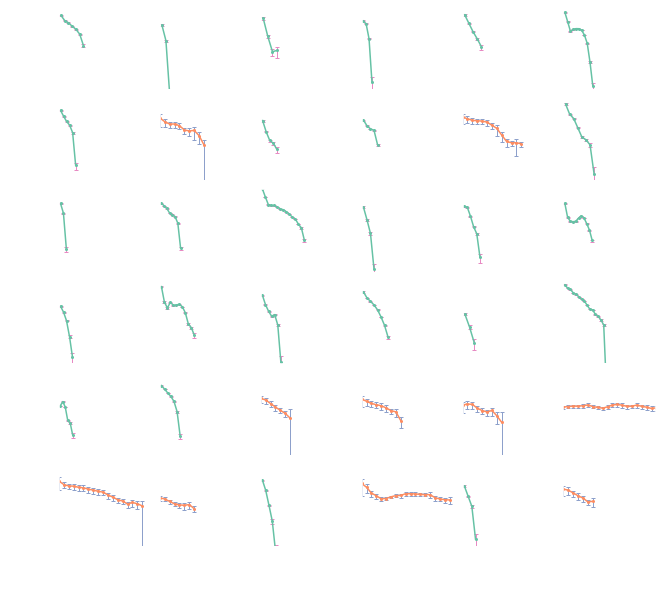

In [9]:
import re


def fix_aspect_ratio_semilogy(ax, aspect_ratio):
    """
    Set the aspect ratio of a plot.
    """
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xrange = xlim[1] - xlim[0]
    yrange = np.log10(ylim[1]) - np.log10(ylim[0])
    ax.set_aspect(aspect_ratio * xrange / yrange, adjustable="box")


#
# Plot 1 radial profile per subplot
#
with plt.style.context("/arc/home/IsaacCheng/coop_f2021/stylesheets/beamer.mplstyle"):
    fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(9, 8), sharex=True, sharey=True)
    for ax, galname, i in zip(axs.flatten(), NGVS_GALAXIES[NGVS_DECR_MEDIAN_M_DENSITY_IDX], NGVS_INCLINATIONS[NGVS_DECR_MEDIAN_M_DENSITY_IDX]):
        is_high_i = i >= i_threshold
        galidx = galaxies.index(galname)
        if is_high_i:
            tmp_color = sns.color_palette("Set2")[1]
            tmp_ecolor = sns.color_palette("Set2")[2]
        else:
            tmp_color = sns.color_palette("Set2")[0]
            tmp_ecolor = sns.color_palette("Set2")[3]
        ebar = ax.errorbar(
            x=radius_kpc[galidx],
            y=radial_profiles[galidx].avg_data,
            yerr=radial_profiles[galidx].avg_data_err,
            fmt="-o",
            markersize=2,
            color=tmp_color,
            ecolor=tmp_ecolor,
            elinewidth=1,
            capsize=2,
        )
        ax.set_ylim(1e-3, 3e2)
        ax.set_xlim(0, 27)
        ax.set_xticks([0, 10, 20])
        ax.semilogy()
        fix_aspect_ratio_semilogy(ax, 0.9)
        # Galaxy name in top right corner + add space between letters and numbers in galname
        high_i_str = "*" if is_high_i else ""
        ax.text(0.9, 0.8, re.sub(r"(\d+)", " \\1", galname) + high_i_str, c="w", ha="right", transform=ax.transAxes)
        ax.grid(False)
    # #
    # # Plot all radial profiles in 1 subplot
    # #
    # for galname in galaxies:
    #     galidx = galaxies.index(galname)
    #     axs[-1, -1].plot(
    #         radius_kpc[galidx], radial_profiles[galidx].avg_data, lw=0.5
    #     )
    # axs[-1, -1].text(0.9, 0.8, "All", c="k", ha="right", transform=axs[-1, -1].transAxes)
    # axs[-1, -1].set_ylim(1e-3, 3e2)
    # axs[-1, -1].set_xlim(0, 27)
    # axs[-1, -1].semilogy()
    # fix_aspect_ratio_semilogy(axs[-1, -1], 0.625)
    # axs[-1, -1].grid(False)
    #
    # Common x- and y-axis labels
    #
    # for ax in axs[-1, :]:
    #     ax.set_xlabel("Radius [kpc]")
    # for ax in axs[:, 0]:
    #     ax.set_ylabel(r"$\Sigma_{\rm mol}$ [$\rm M_\odot\; pc^{-2}$]")
    fig.text(0.5, 0.0, "Radius [kpc]", ha="center", fontsize=15, color="w")
    fig.text(
        0.0,
        0.5,
        f"{avg_function.capitalize()} " + r"$\Sigma_{\rm mol}$ [$\rm M_\odot\; pc^{-2}$]",
        va="center",
        rotation="vertical",
        fontsize=15,
        color="w",
    )
    #
    plt.subplots_adjust(left=0.08, right=1.0, bottom=0.05, top=1.0, wspace=0.1, hspace=0.02)
    # fig.savefig("/arc/home/IsaacCheng/coop_f2021/galaxies/gas_densities/gas_density_i_corr_NGVS-VERTICO_DecrMedianSigmaStar_beamer.pdf")
    plt.show()